## Style Transfer Using GAN

### Variables, Hyperparamaters and libraries import

In [209]:
# %pip install pandas numpy tensorflow matplotlib imageio scikit-image
# %pip install git+https://github.com/tensorflow/docs
import os 
import time
import glob
import imageio
import numpy as np
import pandas as pd
import tensorflow as tf
from skimage.io import imread 
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.utils import plot_model
import tensorflow_docs.vis.embed as embed

In [210]:
SOURCE_FOLDER = './Source/'
T1_FOLDER = SOURCE_FOLDER + 'Tr1/TrainT1/'
T2_FOLDER = SOURCE_FOLDER + 'Tr2/TrainT2/'
OUTPUT_FOLDER = './Output/'
TIMESTAMP = str(time.strftime('%Y%m%d%H%M%S'))
TEMP_FOLDER = OUTPUT_FOLDER + TIMESTAMP + '/'
os.mkdir(TEMP_FOLDER)

EPOCHS = 300
BATCH_SIZE = 10 
IMG_HEIGHT = 32
IMG_WIDTH = 32


### Data Initialization

In [211]:
t1_images = glob.glob(T1_FOLDER+'*.png')
t2_images = glob.glob(T2_FOLDER+'*.png')

t1_df = pd.DataFrame({'t1_images': t1_images, 'label': 't1'})
t2_df = pd.DataFrame({'t2_images': t2_images, 'label': 't2'})

### Image Preprocessing

#### Image to Pixel conversion

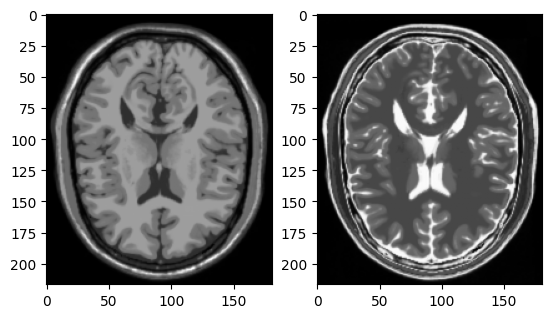

In [212]:
# Convert imaes to pixels and append it to a dataframe

img_lst = []
for idx, img in enumerate(t1_df['t1_images']):
    pxl = imread(img)
    img_lst.append(pxl)
t1_df['img_pxl'] = img_lst

img_lst = []
for idx, img in enumerate(t2_df['t2_images']):
    pxl = imread(img)
    img_lst.append(pxl)
t2_df['img_pxl'] = img_lst

fig, axs = plt.subplots(1,2)
axs[0].imshow(t1_df['img_pxl'][0], cmap='grey')
axs[1].imshow(t2_df['img_pxl'][0], cmap='grey')
plt.show();

#### Image Resizing & pixel Normalization

In [213]:
t1_images = np.zeros((t1_df.shape[0], IMG_HEIGHT, IMG_WIDTH))
t2_images = np.zeros((t2_df.shape[0], IMG_HEIGHT, IMG_WIDTH))

for idx, img in enumerate(t1_df['img_pxl']):
    t1_images[idx, :, :] = resize(img, (IMG_HEIGHT, IMG_WIDTH))
    
for idx, img in enumerate(t2_df['img_pxl']):
    t2_images[idx, :, :] = resize(img, (IMG_HEIGHT, IMG_WIDTH))

t1_images.shape    
t2_images.shape

t1_images = (t1_images/127.5)-1.0
t2_images = (t2_images/127.5)-1.0

(43, 32, 32)

(46, 32, 32)

#### Image Reshaping, Shuffling and Batch Processing

In [214]:
t1_images = t1_images.reshape(t1_images.shape[0], IMG_HEIGHT, IMG_WIDTH, 1).astype('float32')
t2_images = t2_images.reshape(t2_images.shape[0], IMG_HEIGHT, IMG_WIDTH, 1).astype('float32')

t1_img_data = tf.data.Dataset.from_tensor_slices(t1_images).shuffle(t1_images.shape[0], seed=100).batch(BATCH_SIZE)
t2_img_data = tf.data.Dataset.from_tensor_slices(t2_images).shuffle(t2_images.shape[0], seed=100).batch(BATCH_SIZE)

sample_t1_data = next(iter(t1_img_data))
sample_t2_data = next(iter(t2_img_data))

#### Augmentation Tryouts

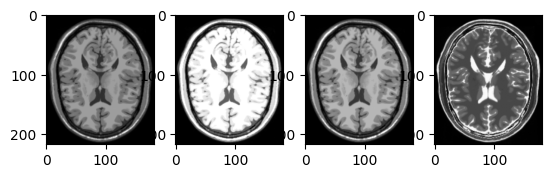

In [215]:
seed = (1, 2)
fig, axs = plt.subplots(1,4)

axs[0].imshow(t1_df['img_pxl'][0], cmap='grey')
axs[1].imshow(tf.image.adjust_brightness(t1_df['img_pxl'][0], delta=0.5), cmap='grey')
axs[2].imshow(tf.image.stateless_random_brightness(t1_df['img_pxl'][0], 0.2, seed), cmap='grey')
axs[3].imshow(t2_df['img_pxl'][0], cmap='grey')
plt.show();


### Loss Functions & Optimizer 

In [216]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5 * loss

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### Model Building

#### Instance Normalization

In [217]:
class InstanceNormalization(tf.keras.layers.Layer):
    # Initialization of Objects
    def __init__(self, epsilon=1e-5):
        # calling parent's init
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    
    def call(self, x):
        # Compute Mean and Variance, Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

#### Downsampling and Upsampling

In [218]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Conv2d layer
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    # Add Normalization layer
    if apply_norm:
        result.add(InstanceNormalization())
    # Add Leaky Relu Activation
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Transposed Conv2d layer
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    # Add Normalization Layer
    result.add(InstanceNormalization())
    # Conditionally add Dropout layer
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    # Add Relu Activation Layer
    result.add(tf.keras.layers.ReLU())
    return result

#### Generator

In [219]:
# Unet Generator is a combination of Convolution + Transposed Convolution Layers
def unet_generator():
    down_stack = [
        downsample(64, 4, False), # (bs, 16, 16, 64)
        downsample(128, 4), # (bs, 8, 8, 128)
        downsample(128, 4), # (bs, 4, 4, 128)
        downsample(128, 4), # (bs, 2, 2, 128)
        downsample(128, 4) # (bs, 1, 1, 128)
    ]
    up_stack = [
        upsample(128, 4, True), # (bs, 2, 2, 256)
        upsample(128, 4, True), # (bs, 4, 4, 256)
        upsample(128, 4), # (bs, 8, 8, 256)
        upsample(64, 4) # (bs, 16, 16, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 32, 32, 1)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[32, 32, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [220]:
generator_g = unet_generator()
generator_f = unet_generator()

generator_g.summary()

Model: "functional_243"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_216     │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_198      │ (None, 16, 16,    │      1,024 │ input_layer_216[… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_199      │ (None, 8, 8, 128) │    131,328 │ sequential_198[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_200      │ (None, 4, 4, 128) │    262,400 │ sequential_199[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_201      │ (None, 2, 2, 128) │    262,400 │ sequential_200[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_202      │ (None, 1, 1, 128) │    262,400 │ sequential_201[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_203      │ (None, 2, 2, 128) │    262,400 │ sequential_202[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 16, 16,    │          0 │ sequential_203[0… │
│ (Concatenate)       │ 128)              │            │ sequential_201[0… │
│                     │                   │            │ sequential_204[0… │
│                     │                   │            │ sequential_200[0… │
│                     │                   │            │ sequential_205[0… │
│                     │                   │            │ sequential_199[0… │
│                     │                   │            │ sequential_206[0… │
│                     │                   │            │ sequential_198[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_204      │ (None, 4, 4, 128) │    524,544 │ concatenate_18[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_205      │ (None, 8, 8, 128) │    524,544 │ concatenate_18[1… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_206      │ (None, 16, 16,    │    262,272 │ concatenate_18[2… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_94 │ (None, 32, 32, 1) │      2,049 │ concatenate_18[3… │
│ (Conv2DTranspose)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,495,361 (9.52 MB)

 Trainable params: 2,495,361 (9.52 MB)

 Non-trainable params: 0 (0.00 B)

#### Discriminator

In [221]:
# Discriminators only contain Convolutional Layers and no Transposed Convolution is not used 
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    # add input layer of size (32, 32, 1)
    inp = tf.keras.layers.Input(shape=[32, 32, 1], name='input_image')
    x = inp
    
    # add downsampling step here
    down1 = downsample(64, 4, False)(x) # (bs, 16, 16, 64)
    down2 = downsample(128, 4)(down1) # (bs, 8, 8, 128)
    # add a padding layer here
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2) # (bs, 10, 10, 128)
    
    # implement a concrete downsampling layer here
    conv = tf.keras.layers.Conv2D(256, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 7, 7, 256)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    
    # apply zero padding layer
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 9, 9, 256)
    
    # add a last pure 2D Convolution layer
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 6, 6, 1)
    return tf.keras.Model(inputs=inp, outputs=last)

In [222]:
discriminator_x = discriminator()
discriminator_y = discriminator()

discriminator_x.summary()

Model: "functional_256"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_216 (Sequential)     │ (None, 16, 16, 64)     │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_217 (Sequential)     │ (None, 8, 8, 128)      │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_36               │ (None, 10, 10, 128)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_174 (Conv2D)             │ (None, 7, 7, 256)      │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ instance_normalization_197      │ (None, 7, 7, 256)      │           512 │
│ (InstanceNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_156 (LeakyReLU)     │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_37               │ (None, 9, 9, 256)      │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_175 (Conv2D)             │ (None, 6, 6, 1)        │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 661,249 (2.52 MB)

 Trainable params: 661,249 (2.52 MB)

 Non-trainable params: 0 (0.00 B)

<Figure size 400x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'T1_Img_data')

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'To T2_Img_data')

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'T2_Img_data')

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

<Axes: >

Text(0.5, 1.0, 'To T1_Img_data')

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

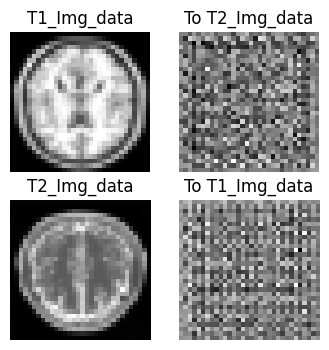

In [223]:
to_t2_img_data = generator_g(sample_t1_data)
to_t1_img_data = generator_f(sample_t2_data)
plt.figure(figsize=(4, 4))

imgs = [sample_t1_data, to_t2_img_data, sample_t2_data, to_t1_img_data]
title = ['T1_Img_data', 'To T2_Img_data', 'T2_Img_data', 'To T1_Img_data']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0], cmap='gray')
    plt.axis('off')
plt.show()

### Model Training

#### Checkpoint Initialization

In [224]:
checkpoint_path = TEMP_FOLDER +"Trained_Model"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [225]:
def generate_images(model1, test_input1, model2, test_input2, epoch):
    prediction1 = model1(test_input1)
    prediction2 = model2(test_input2)
    plt.figure(figsize=(8, 4))
    display_list = [test_input1[0], prediction1[0], test_input2[0], prediction2[0]]
    title = ['Input Image', 'Predicted Image', 'Input Image', 'Predicted Image']
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig(TEMP_FOLDER +'image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [226]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)
        
        # Total generator loss = BCE loss + cycle loss + identity loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        # Discriminator's loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

E0000 00:00:1746107611.145632  288730 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_243_1/sequential_203_1/dropout_36_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


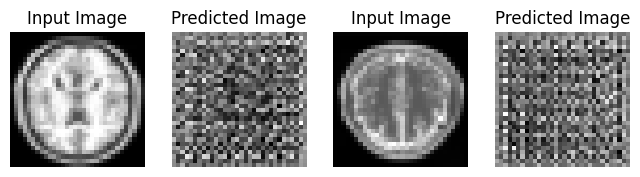

Saving checkpoint for epoch 1 at ./Output/20250501192317/Trained_Model/ckpt-1


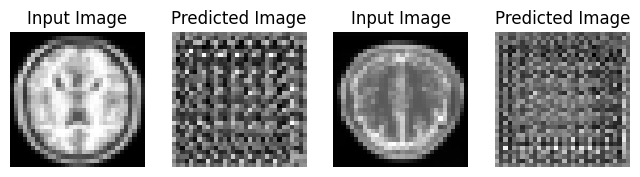

Saving checkpoint for epoch 2 at ./Output/20250501192317/Trained_Model/ckpt-2


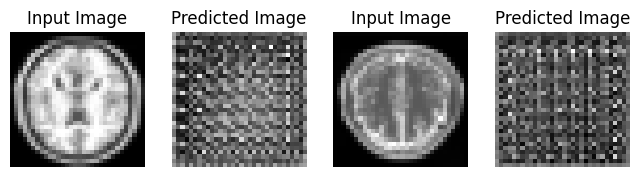

Saving checkpoint for epoch 3 at ./Output/20250501192317/Trained_Model/ckpt-3


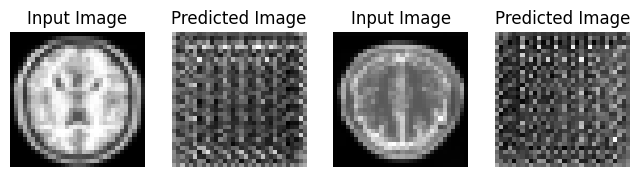

Saving checkpoint for epoch 4 at ./Output/20250501192317/Trained_Model/ckpt-4


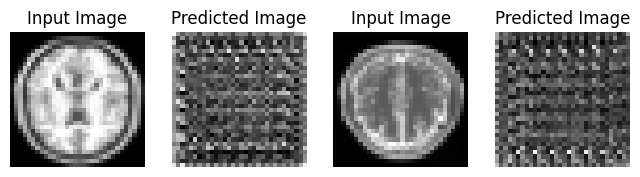

Saving checkpoint for epoch 5 at ./Output/20250501192317/Trained_Model/ckpt-5


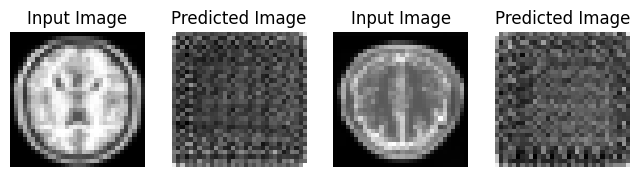

Saving checkpoint for epoch 6 at ./Output/20250501192317/Trained_Model/ckpt-6


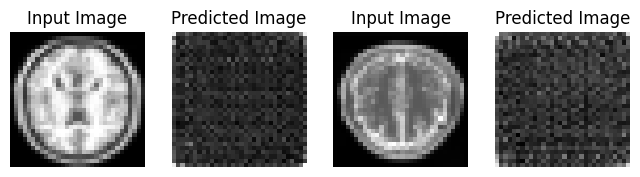

Saving checkpoint for epoch 7 at ./Output/20250501192317/Trained_Model/ckpt-7


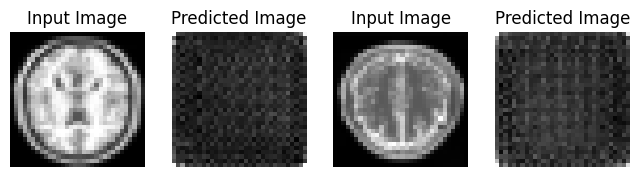

Saving checkpoint for epoch 8 at ./Output/20250501192317/Trained_Model/ckpt-8


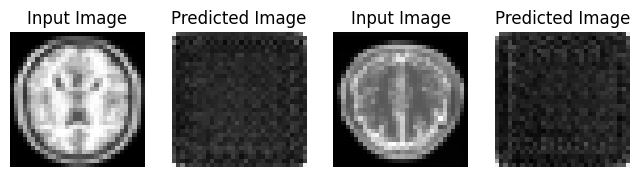

Saving checkpoint for epoch 9 at ./Output/20250501192317/Trained_Model/ckpt-9


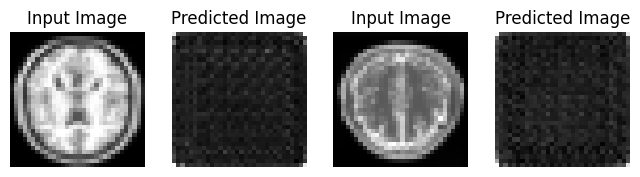

Saving checkpoint for epoch 10 at ./Output/20250501192317/Trained_Model/ckpt-10


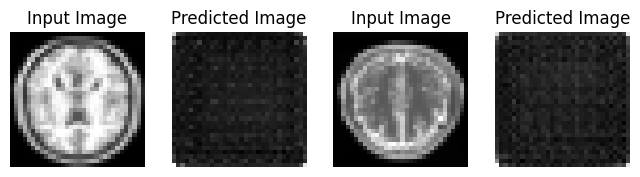

Saving checkpoint for epoch 11 at ./Output/20250501192317/Trained_Model/ckpt-11


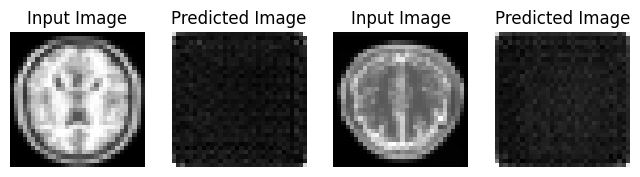

Saving checkpoint for epoch 12 at ./Output/20250501192317/Trained_Model/ckpt-12


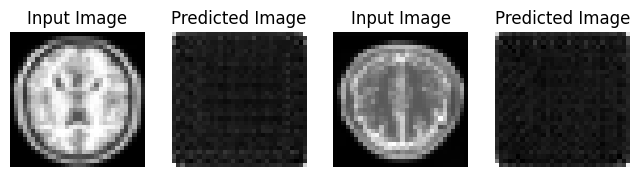

Saving checkpoint for epoch 13 at ./Output/20250501192317/Trained_Model/ckpt-13


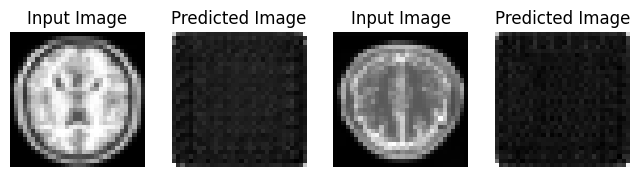

Saving checkpoint for epoch 14 at ./Output/20250501192317/Trained_Model/ckpt-14


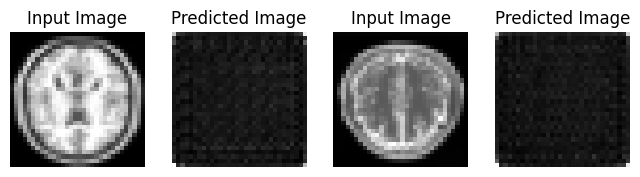

Saving checkpoint for epoch 15 at ./Output/20250501192317/Trained_Model/ckpt-15


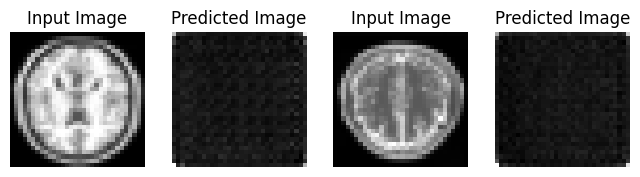

Saving checkpoint for epoch 16 at ./Output/20250501192317/Trained_Model/ckpt-16


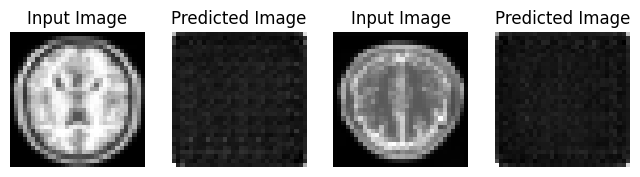

Saving checkpoint for epoch 17 at ./Output/20250501192317/Trained_Model/ckpt-17


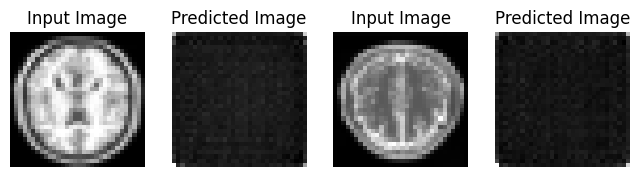

Saving checkpoint for epoch 18 at ./Output/20250501192317/Trained_Model/ckpt-18


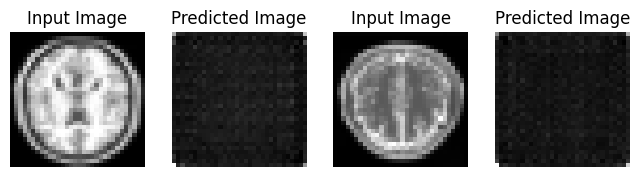

Saving checkpoint for epoch 19 at ./Output/20250501192317/Trained_Model/ckpt-19


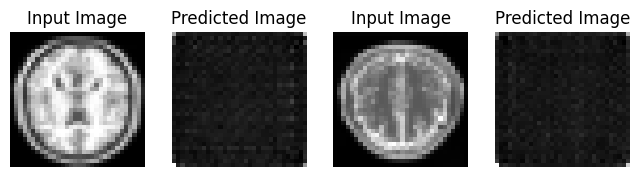

Saving checkpoint for epoch 20 at ./Output/20250501192317/Trained_Model/ckpt-20


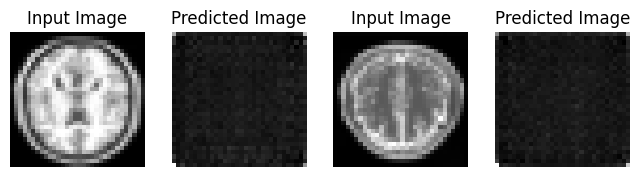

Saving checkpoint for epoch 21 at ./Output/20250501192317/Trained_Model/ckpt-21


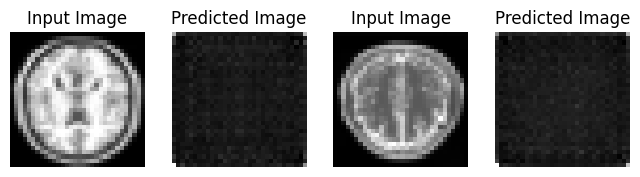

Saving checkpoint for epoch 22 at ./Output/20250501192317/Trained_Model/ckpt-22


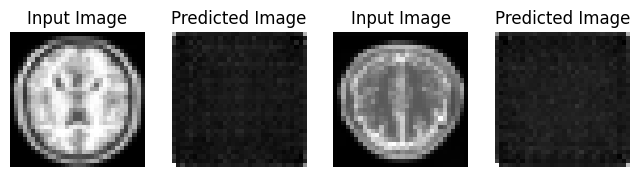

Saving checkpoint for epoch 23 at ./Output/20250501192317/Trained_Model/ckpt-23


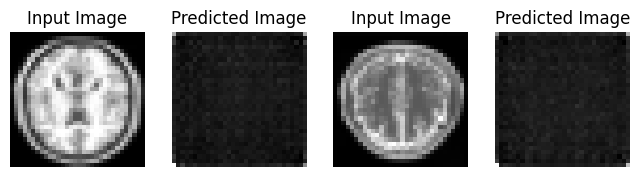

Saving checkpoint for epoch 24 at ./Output/20250501192317/Trained_Model/ckpt-24


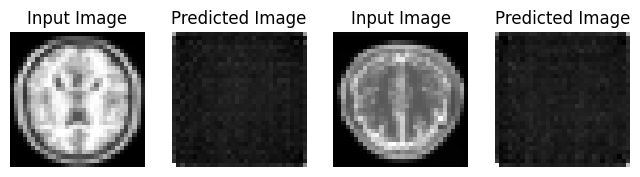

Saving checkpoint for epoch 25 at ./Output/20250501192317/Trained_Model/ckpt-25


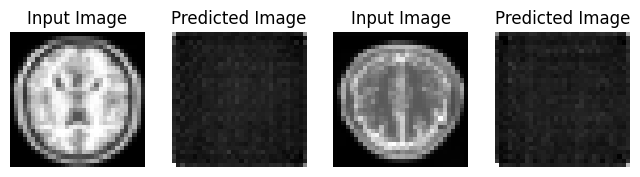

Saving checkpoint for epoch 26 at ./Output/20250501192317/Trained_Model/ckpt-26


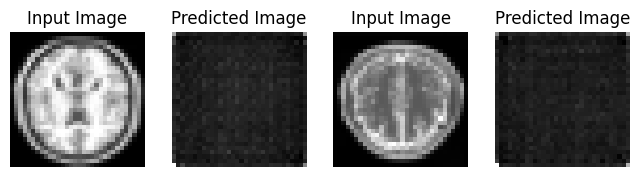

Saving checkpoint for epoch 27 at ./Output/20250501192317/Trained_Model/ckpt-27


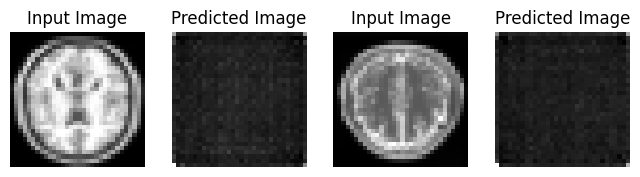

Saving checkpoint for epoch 28 at ./Output/20250501192317/Trained_Model/ckpt-28


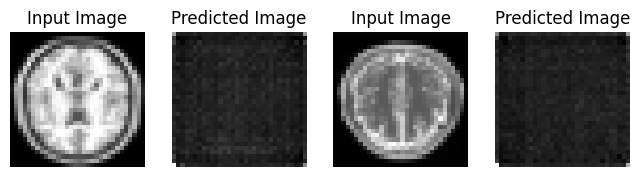

Saving checkpoint for epoch 29 at ./Output/20250501192317/Trained_Model/ckpt-29


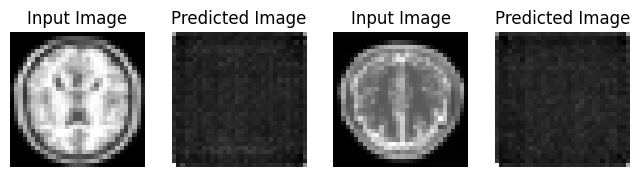

Saving checkpoint for epoch 30 at ./Output/20250501192317/Trained_Model/ckpt-30


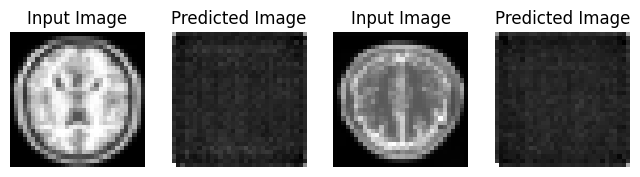

Saving checkpoint for epoch 31 at ./Output/20250501192317/Trained_Model/ckpt-31


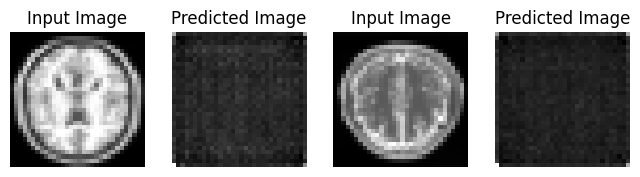

Saving checkpoint for epoch 32 at ./Output/20250501192317/Trained_Model/ckpt-32


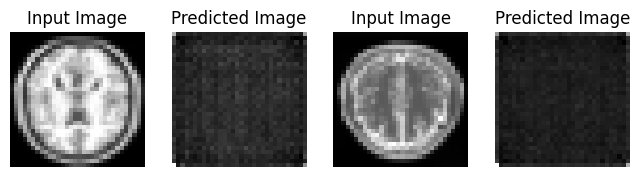

Saving checkpoint for epoch 33 at ./Output/20250501192317/Trained_Model/ckpt-33


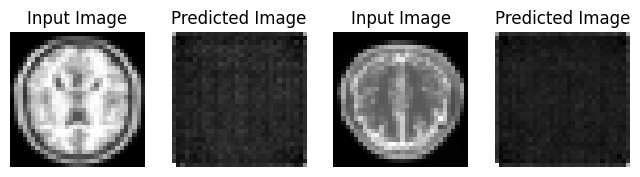

Saving checkpoint for epoch 34 at ./Output/20250501192317/Trained_Model/ckpt-34


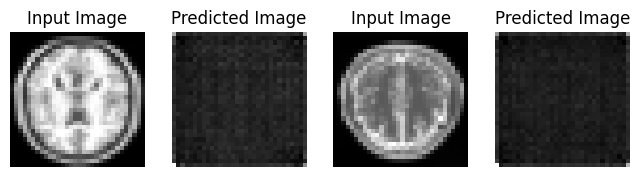

Saving checkpoint for epoch 35 at ./Output/20250501192317/Trained_Model/ckpt-35


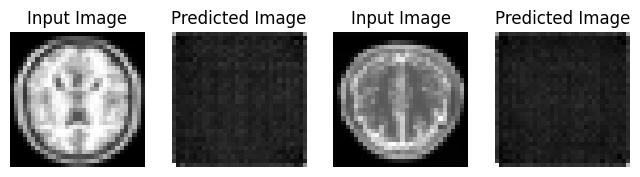

Saving checkpoint for epoch 36 at ./Output/20250501192317/Trained_Model/ckpt-36


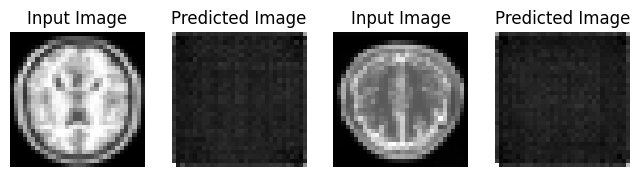

Saving checkpoint for epoch 37 at ./Output/20250501192317/Trained_Model/ckpt-37


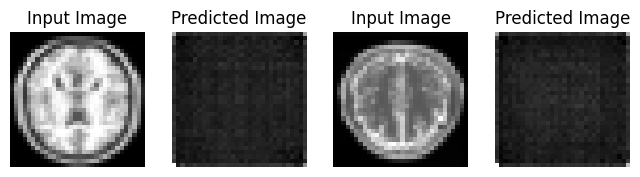

Saving checkpoint for epoch 38 at ./Output/20250501192317/Trained_Model/ckpt-38


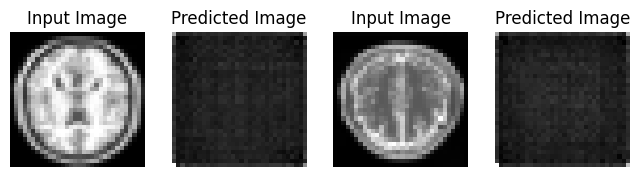

Saving checkpoint for epoch 39 at ./Output/20250501192317/Trained_Model/ckpt-39


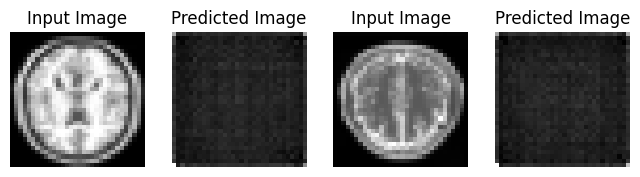

Saving checkpoint for epoch 40 at ./Output/20250501192317/Trained_Model/ckpt-40


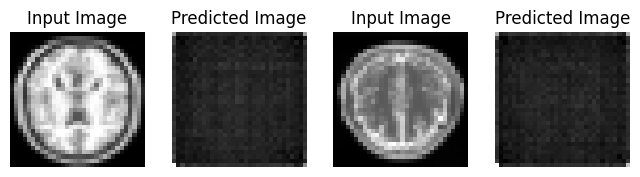

Saving checkpoint for epoch 41 at ./Output/20250501192317/Trained_Model/ckpt-41


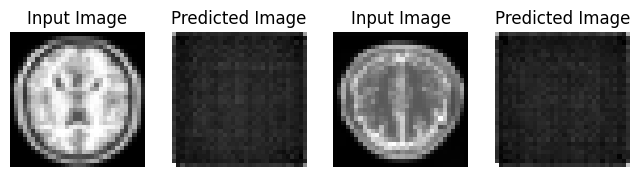

Saving checkpoint for epoch 42 at ./Output/20250501192317/Trained_Model/ckpt-42


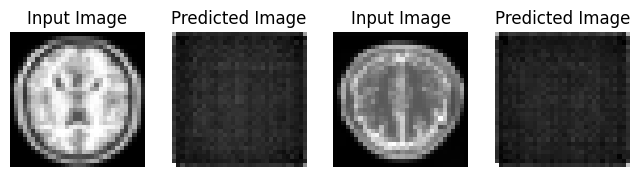

Saving checkpoint for epoch 43 at ./Output/20250501192317/Trained_Model/ckpt-43


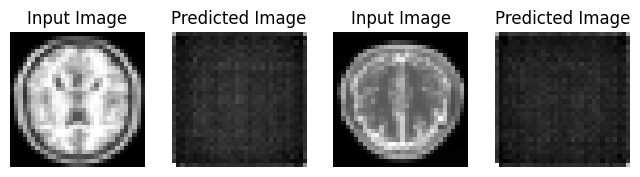

Saving checkpoint for epoch 44 at ./Output/20250501192317/Trained_Model/ckpt-44


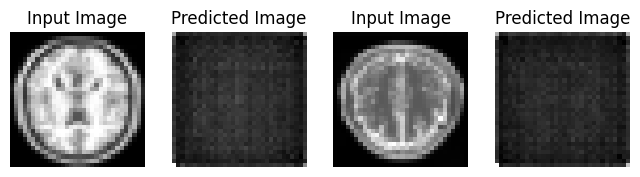

Saving checkpoint for epoch 45 at ./Output/20250501192317/Trained_Model/ckpt-45


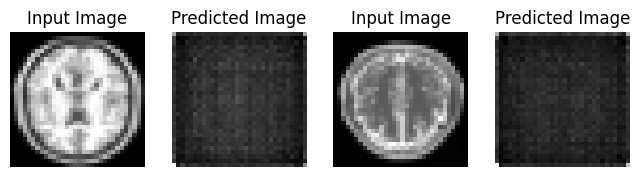

Saving checkpoint for epoch 46 at ./Output/20250501192317/Trained_Model/ckpt-46


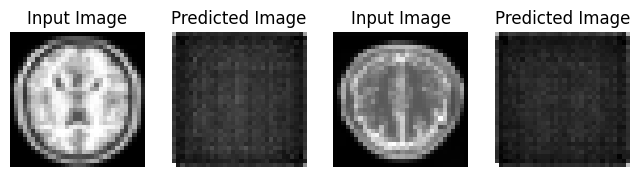

Saving checkpoint for epoch 47 at ./Output/20250501192317/Trained_Model/ckpt-47


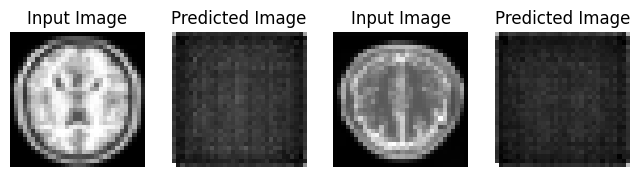

Saving checkpoint for epoch 48 at ./Output/20250501192317/Trained_Model/ckpt-48


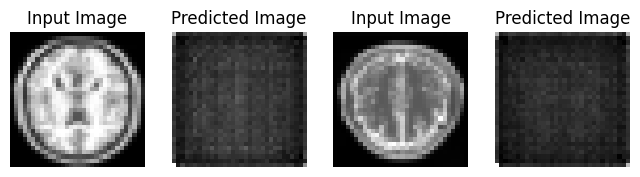

Saving checkpoint for epoch 49 at ./Output/20250501192317/Trained_Model/ckpt-49


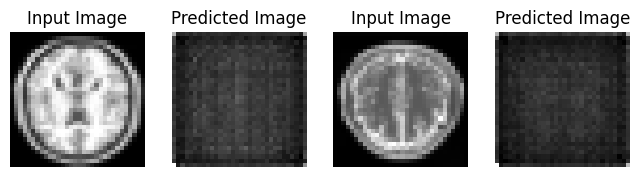

Saving checkpoint for epoch 50 at ./Output/20250501192317/Trained_Model/ckpt-50


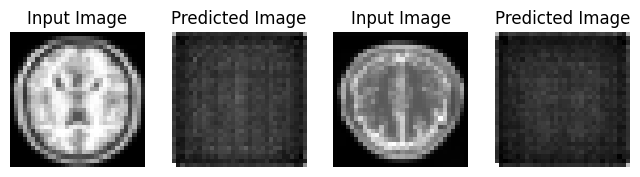

Saving checkpoint for epoch 51 at ./Output/20250501192317/Trained_Model/ckpt-51


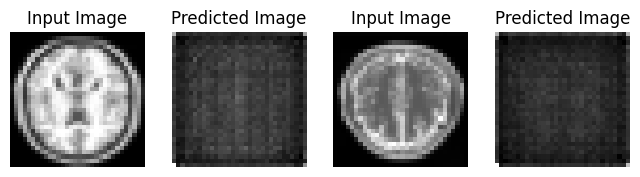

Saving checkpoint for epoch 52 at ./Output/20250501192317/Trained_Model/ckpt-52


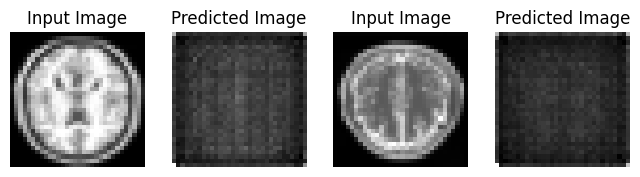

Saving checkpoint for epoch 53 at ./Output/20250501192317/Trained_Model/ckpt-53


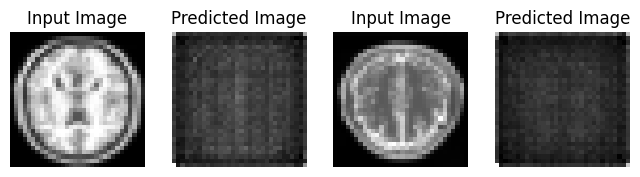

Saving checkpoint for epoch 54 at ./Output/20250501192317/Trained_Model/ckpt-54


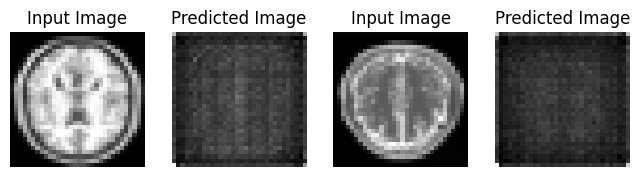

Saving checkpoint for epoch 55 at ./Output/20250501192317/Trained_Model/ckpt-55


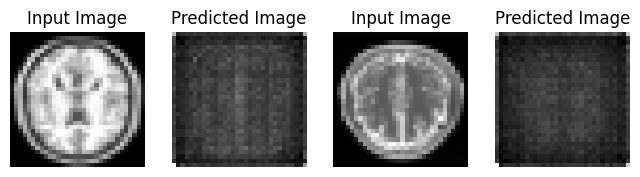

Saving checkpoint for epoch 56 at ./Output/20250501192317/Trained_Model/ckpt-56


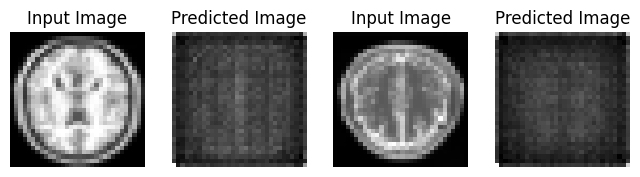

Saving checkpoint for epoch 57 at ./Output/20250501192317/Trained_Model/ckpt-57


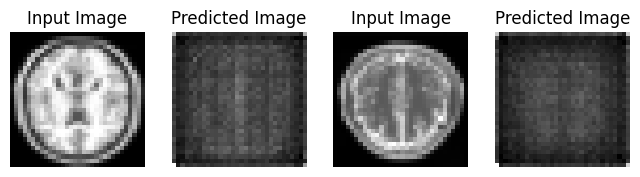

Saving checkpoint for epoch 58 at ./Output/20250501192317/Trained_Model/ckpt-58


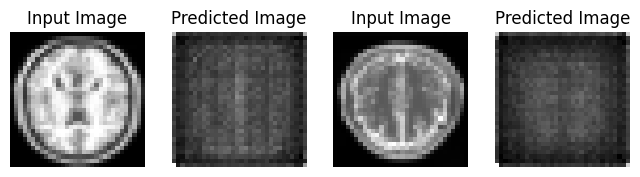

Saving checkpoint for epoch 59 at ./Output/20250501192317/Trained_Model/ckpt-59


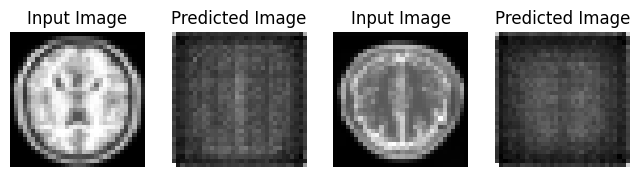

Saving checkpoint for epoch 60 at ./Output/20250501192317/Trained_Model/ckpt-60


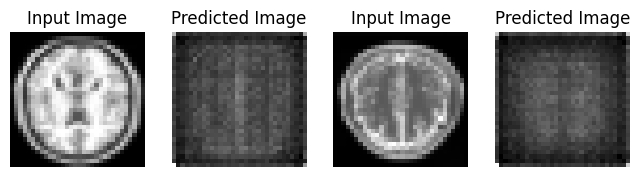

Saving checkpoint for epoch 61 at ./Output/20250501192317/Trained_Model/ckpt-61


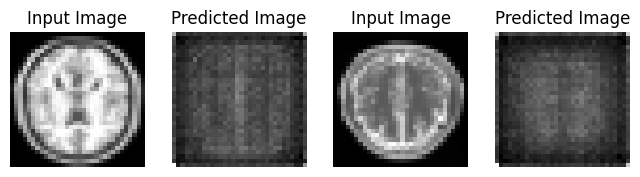

Saving checkpoint for epoch 62 at ./Output/20250501192317/Trained_Model/ckpt-62


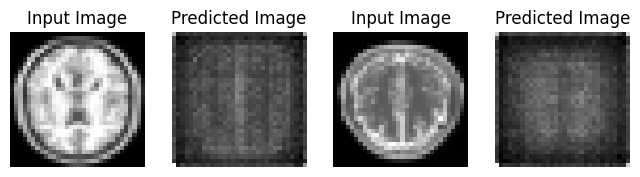

Saving checkpoint for epoch 63 at ./Output/20250501192317/Trained_Model/ckpt-63


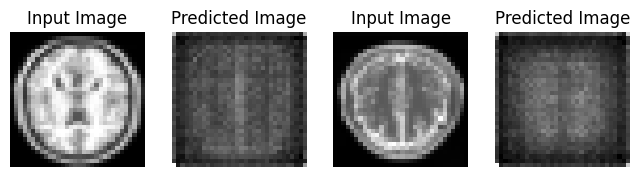

Saving checkpoint for epoch 64 at ./Output/20250501192317/Trained_Model/ckpt-64


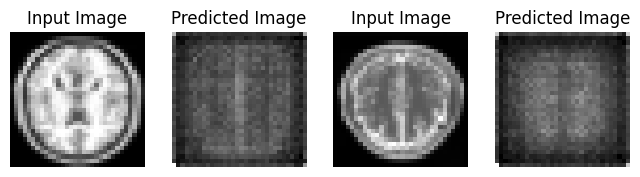

Saving checkpoint for epoch 65 at ./Output/20250501192317/Trained_Model/ckpt-65


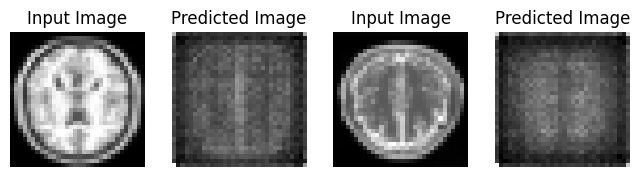

Saving checkpoint for epoch 66 at ./Output/20250501192317/Trained_Model/ckpt-66


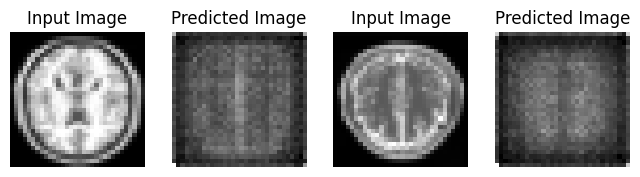

Saving checkpoint for epoch 67 at ./Output/20250501192317/Trained_Model/ckpt-67


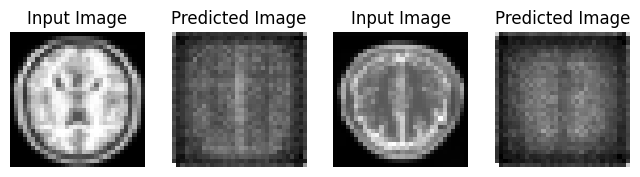

Saving checkpoint for epoch 68 at ./Output/20250501192317/Trained_Model/ckpt-68


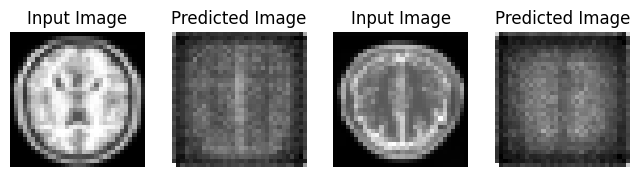

Saving checkpoint for epoch 69 at ./Output/20250501192317/Trained_Model/ckpt-69


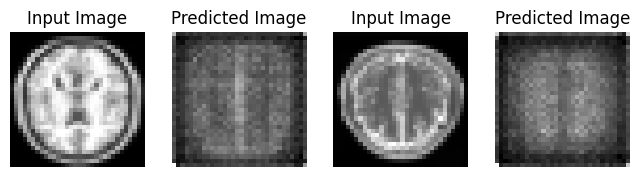

Saving checkpoint for epoch 70 at ./Output/20250501192317/Trained_Model/ckpt-70


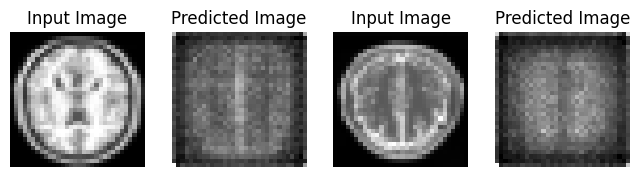

Saving checkpoint for epoch 71 at ./Output/20250501192317/Trained_Model/ckpt-71


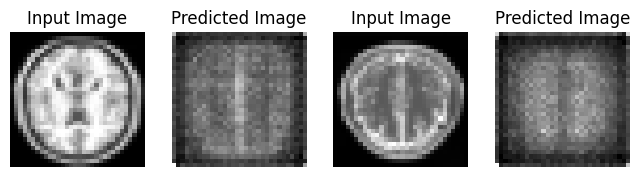

Saving checkpoint for epoch 72 at ./Output/20250501192317/Trained_Model/ckpt-72


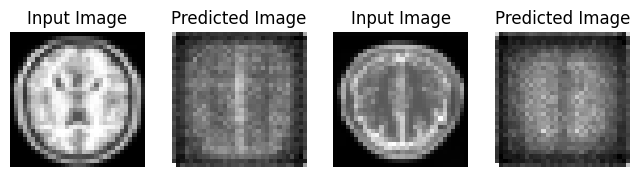

Saving checkpoint for epoch 73 at ./Output/20250501192317/Trained_Model/ckpt-73


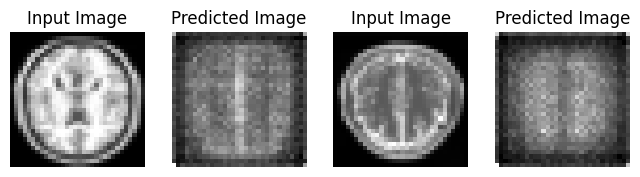

Saving checkpoint for epoch 74 at ./Output/20250501192317/Trained_Model/ckpt-74


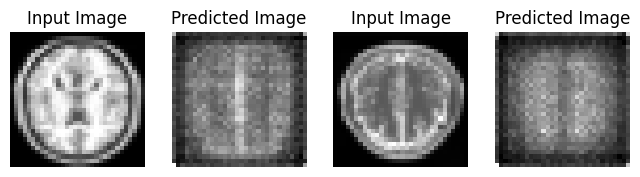

Saving checkpoint for epoch 75 at ./Output/20250501192317/Trained_Model/ckpt-75


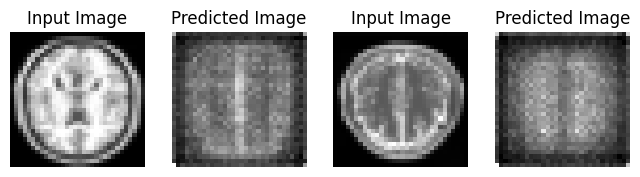

Saving checkpoint for epoch 76 at ./Output/20250501192317/Trained_Model/ckpt-76


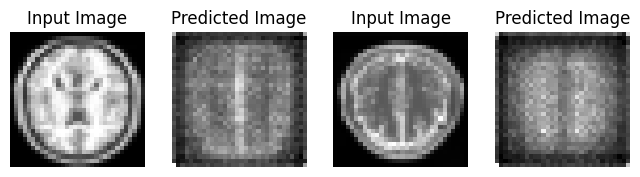

Saving checkpoint for epoch 77 at ./Output/20250501192317/Trained_Model/ckpt-77


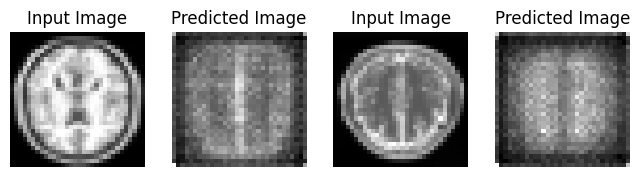

Saving checkpoint for epoch 78 at ./Output/20250501192317/Trained_Model/ckpt-78


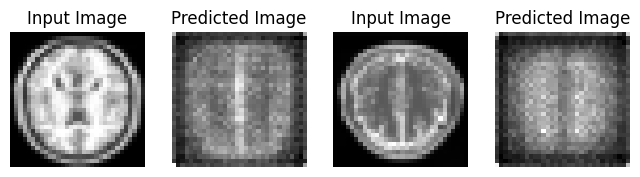

Saving checkpoint for epoch 79 at ./Output/20250501192317/Trained_Model/ckpt-79


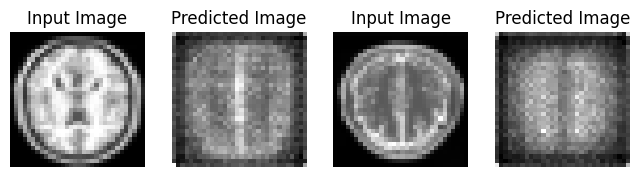

Saving checkpoint for epoch 80 at ./Output/20250501192317/Trained_Model/ckpt-80


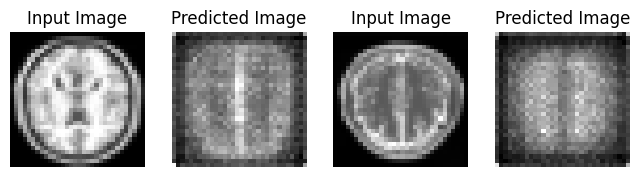

Saving checkpoint for epoch 81 at ./Output/20250501192317/Trained_Model/ckpt-81


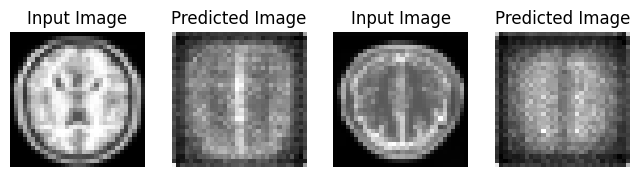

Saving checkpoint for epoch 82 at ./Output/20250501192317/Trained_Model/ckpt-82


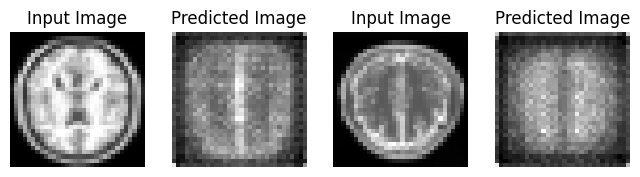

Saving checkpoint for epoch 83 at ./Output/20250501192317/Trained_Model/ckpt-83


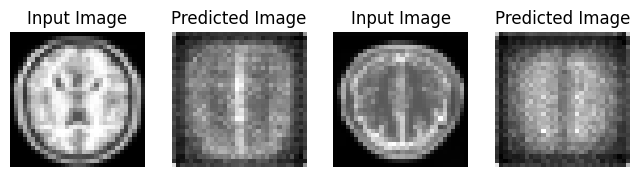

Saving checkpoint for epoch 84 at ./Output/20250501192317/Trained_Model/ckpt-84


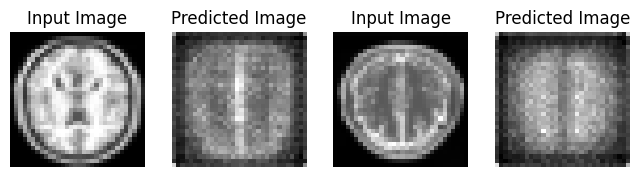

Saving checkpoint for epoch 85 at ./Output/20250501192317/Trained_Model/ckpt-85


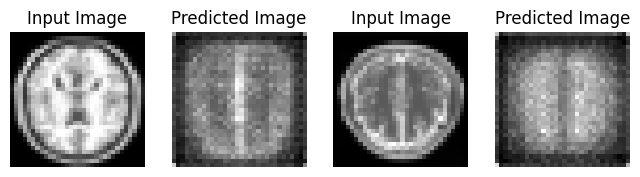

Saving checkpoint for epoch 86 at ./Output/20250501192317/Trained_Model/ckpt-86


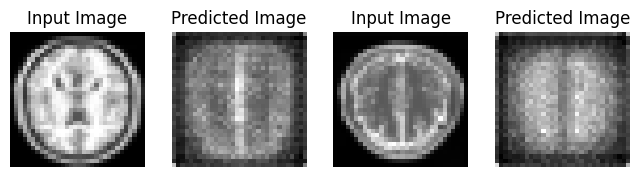

Saving checkpoint for epoch 87 at ./Output/20250501192317/Trained_Model/ckpt-87


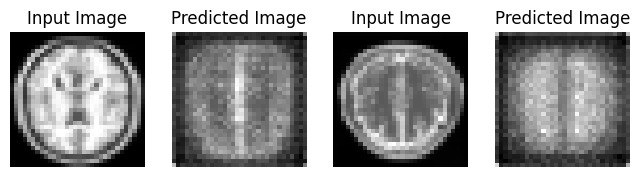

Saving checkpoint for epoch 88 at ./Output/20250501192317/Trained_Model/ckpt-88


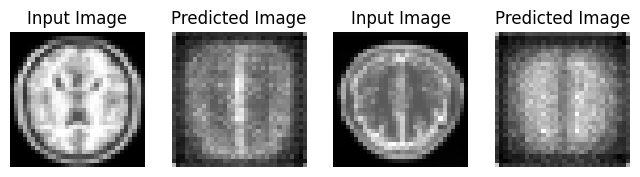

Saving checkpoint for epoch 89 at ./Output/20250501192317/Trained_Model/ckpt-89


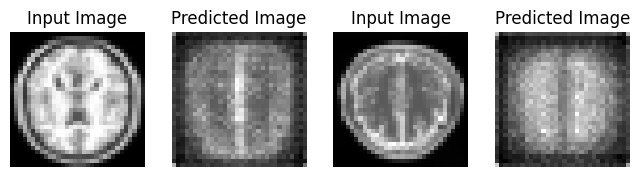

Saving checkpoint for epoch 90 at ./Output/20250501192317/Trained_Model/ckpt-90


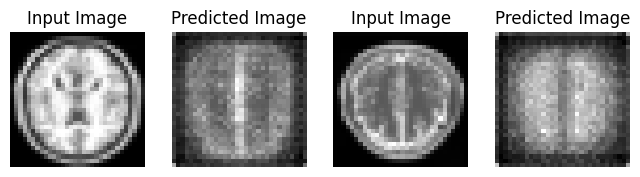

Saving checkpoint for epoch 91 at ./Output/20250501192317/Trained_Model/ckpt-91


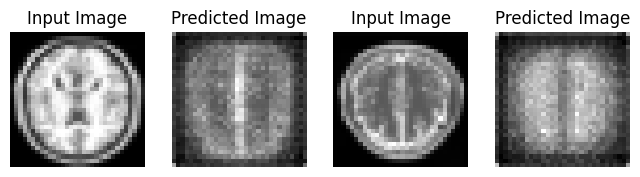

Saving checkpoint for epoch 92 at ./Output/20250501192317/Trained_Model/ckpt-92


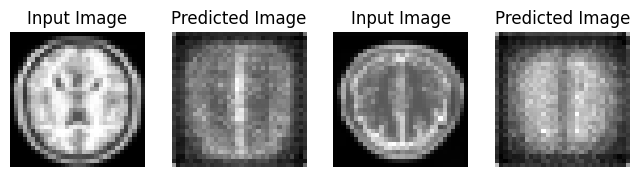

Saving checkpoint for epoch 93 at ./Output/20250501192317/Trained_Model/ckpt-93


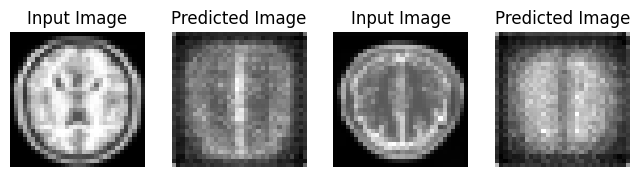

Saving checkpoint for epoch 94 at ./Output/20250501192317/Trained_Model/ckpt-94


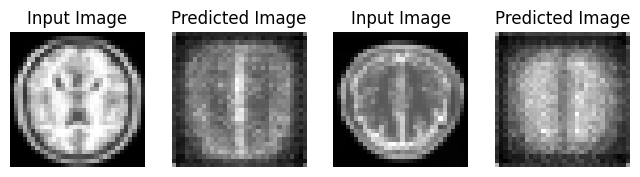

Saving checkpoint for epoch 95 at ./Output/20250501192317/Trained_Model/ckpt-95


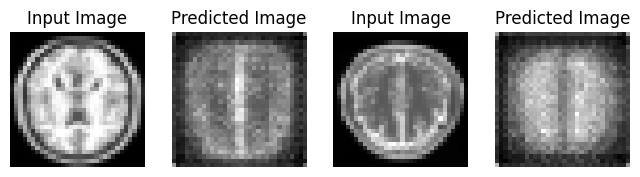

Saving checkpoint for epoch 96 at ./Output/20250501192317/Trained_Model/ckpt-96


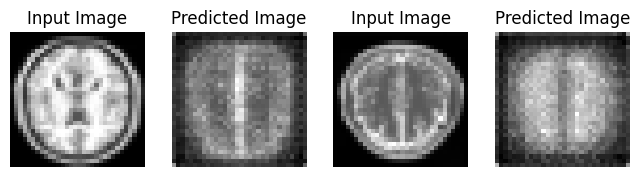

Saving checkpoint for epoch 97 at ./Output/20250501192317/Trained_Model/ckpt-97


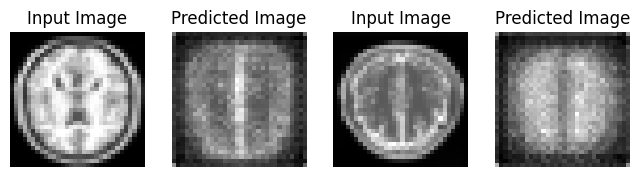

Saving checkpoint for epoch 98 at ./Output/20250501192317/Trained_Model/ckpt-98


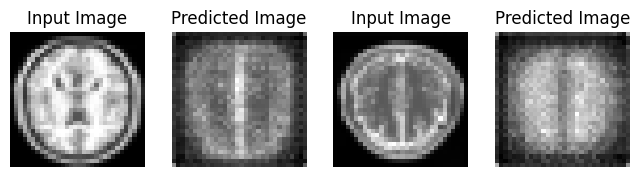

Saving checkpoint for epoch 99 at ./Output/20250501192317/Trained_Model/ckpt-99


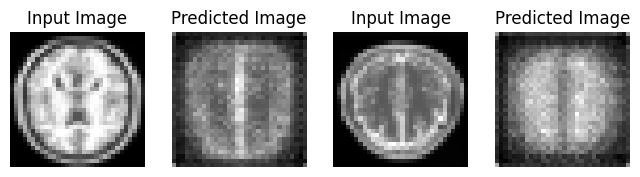

Saving checkpoint for epoch 100 at ./Output/20250501192317/Trained_Model/ckpt-100


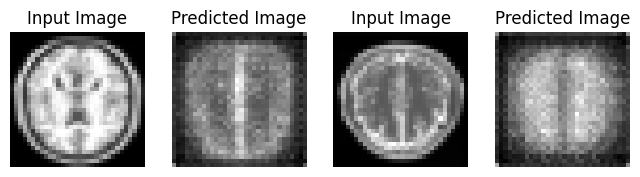

Saving checkpoint for epoch 101 at ./Output/20250501192317/Trained_Model/ckpt-101


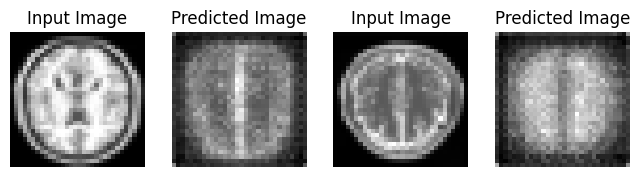

Saving checkpoint for epoch 102 at ./Output/20250501192317/Trained_Model/ckpt-102


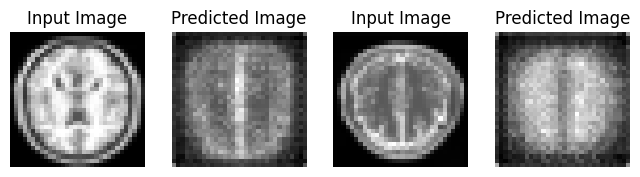

Saving checkpoint for epoch 103 at ./Output/20250501192317/Trained_Model/ckpt-103


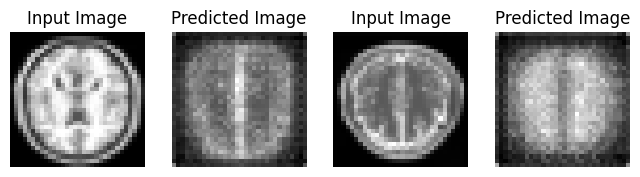

Saving checkpoint for epoch 104 at ./Output/20250501192317/Trained_Model/ckpt-104


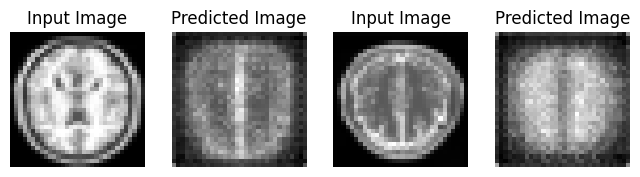

Saving checkpoint for epoch 105 at ./Output/20250501192317/Trained_Model/ckpt-105


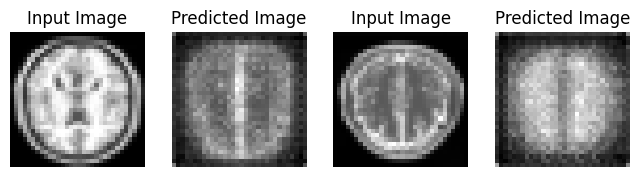

Saving checkpoint for epoch 106 at ./Output/20250501192317/Trained_Model/ckpt-106


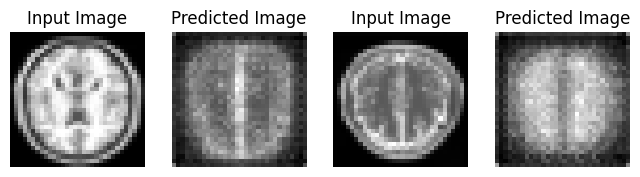

Saving checkpoint for epoch 107 at ./Output/20250501192317/Trained_Model/ckpt-107


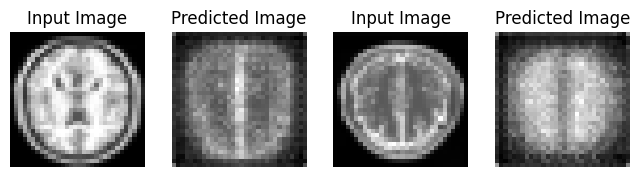

Saving checkpoint for epoch 108 at ./Output/20250501192317/Trained_Model/ckpt-108


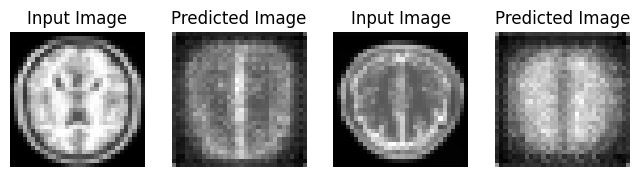

Saving checkpoint for epoch 109 at ./Output/20250501192317/Trained_Model/ckpt-109


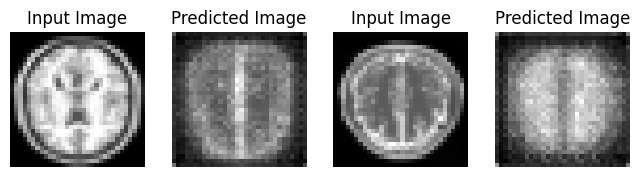

Saving checkpoint for epoch 110 at ./Output/20250501192317/Trained_Model/ckpt-110


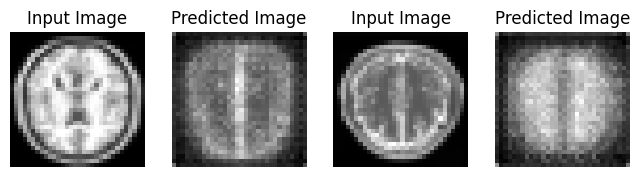

Saving checkpoint for epoch 111 at ./Output/20250501192317/Trained_Model/ckpt-111


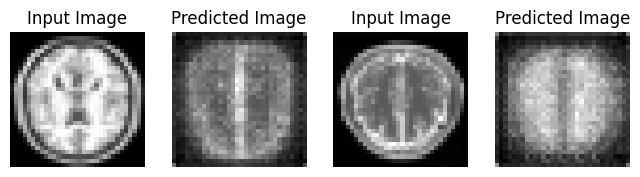

Saving checkpoint for epoch 112 at ./Output/20250501192317/Trained_Model/ckpt-112


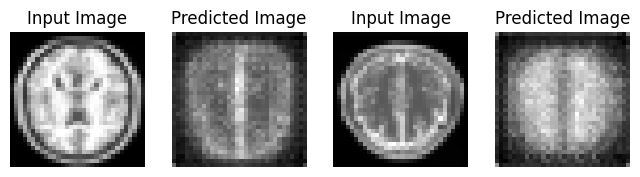

Saving checkpoint for epoch 113 at ./Output/20250501192317/Trained_Model/ckpt-113


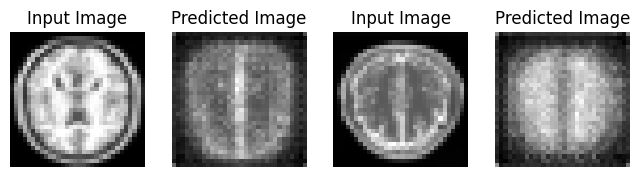

Saving checkpoint for epoch 114 at ./Output/20250501192317/Trained_Model/ckpt-114


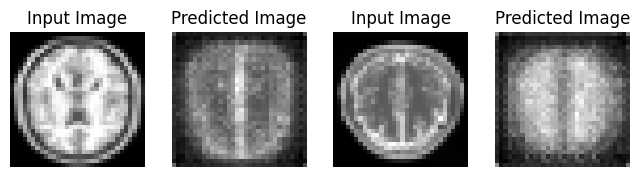

Saving checkpoint for epoch 115 at ./Output/20250501192317/Trained_Model/ckpt-115


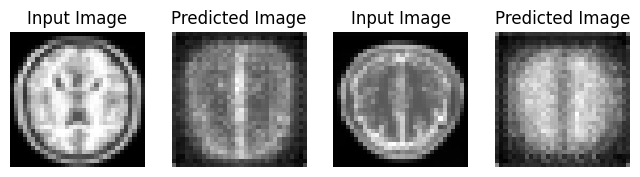

Saving checkpoint for epoch 116 at ./Output/20250501192317/Trained_Model/ckpt-116


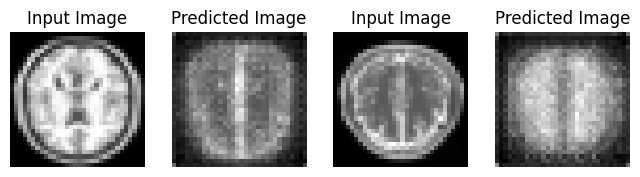

Saving checkpoint for epoch 117 at ./Output/20250501192317/Trained_Model/ckpt-117


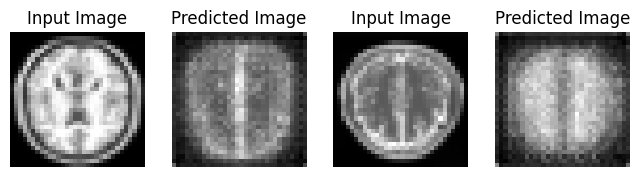

Saving checkpoint for epoch 118 at ./Output/20250501192317/Trained_Model/ckpt-118


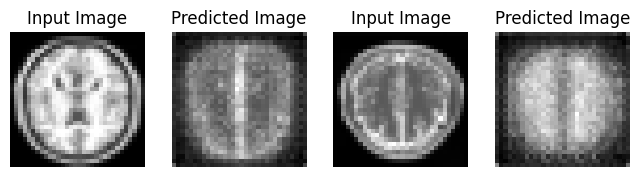

Saving checkpoint for epoch 119 at ./Output/20250501192317/Trained_Model/ckpt-119


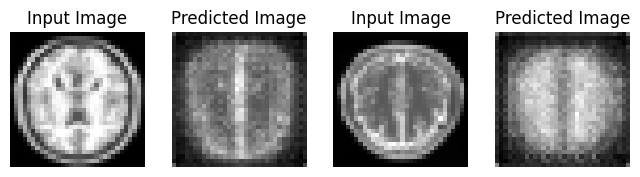

Saving checkpoint for epoch 120 at ./Output/20250501192317/Trained_Model/ckpt-120


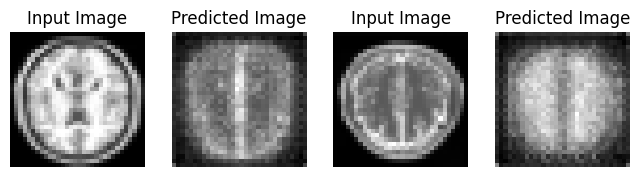

Saving checkpoint for epoch 121 at ./Output/20250501192317/Trained_Model/ckpt-121


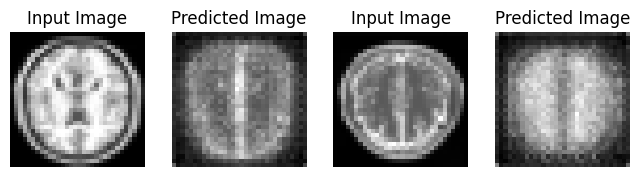

Saving checkpoint for epoch 122 at ./Output/20250501192317/Trained_Model/ckpt-122


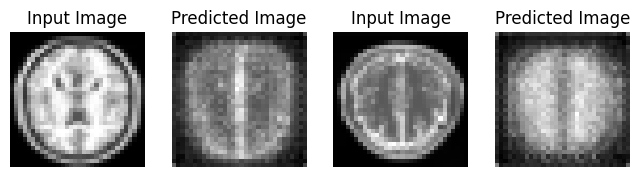

Saving checkpoint for epoch 123 at ./Output/20250501192317/Trained_Model/ckpt-123


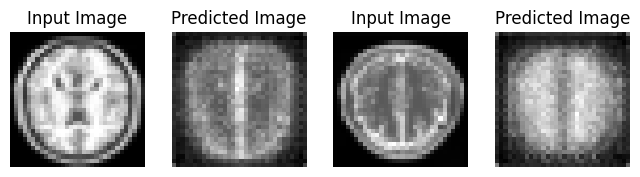

Saving checkpoint for epoch 124 at ./Output/20250501192317/Trained_Model/ckpt-124


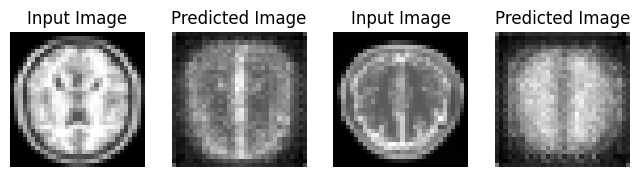

Saving checkpoint for epoch 125 at ./Output/20250501192317/Trained_Model/ckpt-125


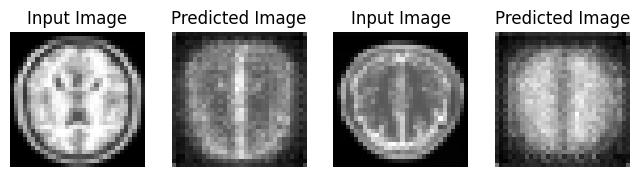

Saving checkpoint for epoch 126 at ./Output/20250501192317/Trained_Model/ckpt-126


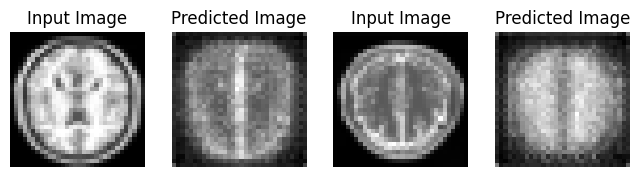

Saving checkpoint for epoch 127 at ./Output/20250501192317/Trained_Model/ckpt-127


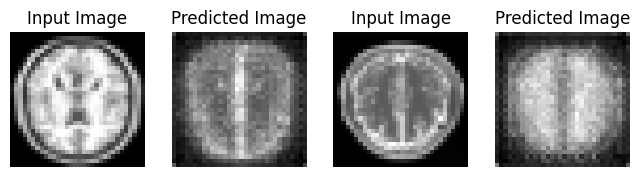

Saving checkpoint for epoch 128 at ./Output/20250501192317/Trained_Model/ckpt-128


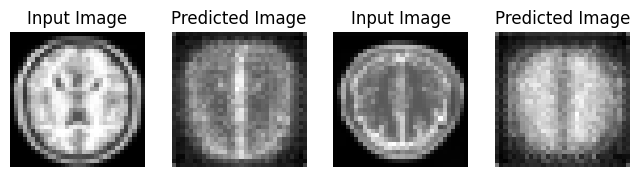

Saving checkpoint for epoch 129 at ./Output/20250501192317/Trained_Model/ckpt-129


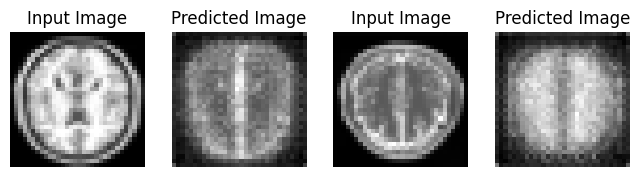

Saving checkpoint for epoch 130 at ./Output/20250501192317/Trained_Model/ckpt-130


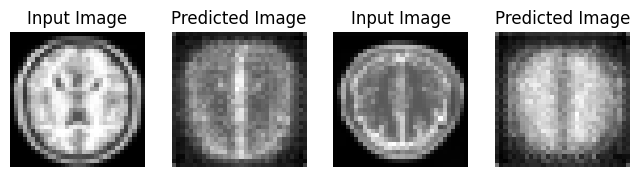

Saving checkpoint for epoch 131 at ./Output/20250501192317/Trained_Model/ckpt-131


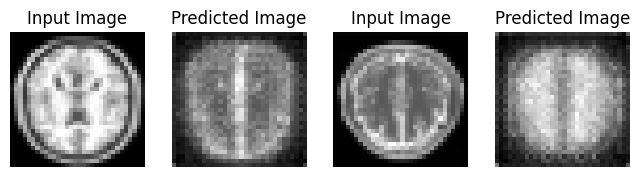

Saving checkpoint for epoch 132 at ./Output/20250501192317/Trained_Model/ckpt-132


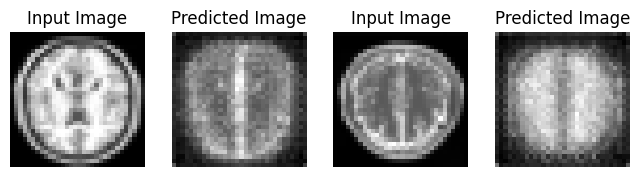

Saving checkpoint for epoch 133 at ./Output/20250501192317/Trained_Model/ckpt-133


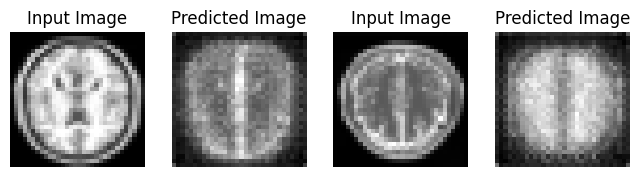

Saving checkpoint for epoch 134 at ./Output/20250501192317/Trained_Model/ckpt-134


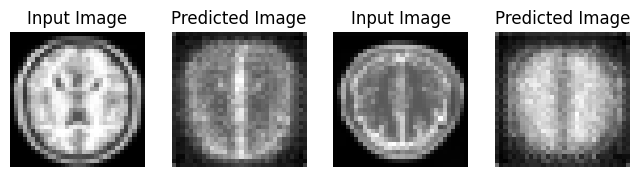

Saving checkpoint for epoch 135 at ./Output/20250501192317/Trained_Model/ckpt-135


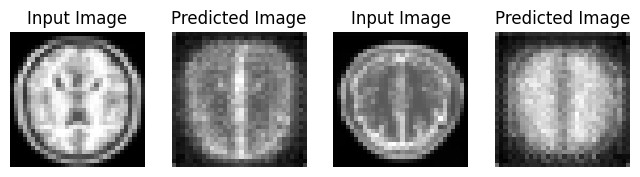

Saving checkpoint for epoch 136 at ./Output/20250501192317/Trained_Model/ckpt-136


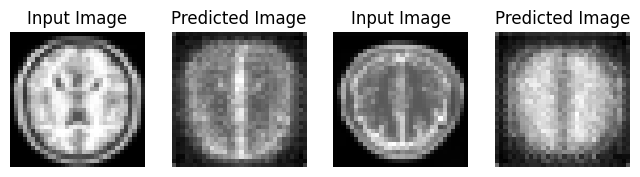

Saving checkpoint for epoch 137 at ./Output/20250501192317/Trained_Model/ckpt-137


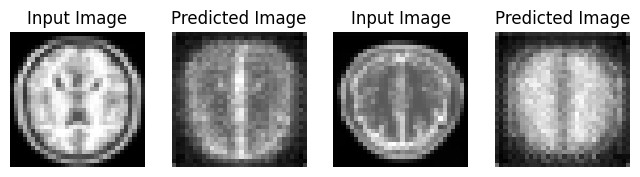

Saving checkpoint for epoch 138 at ./Output/20250501192317/Trained_Model/ckpt-138


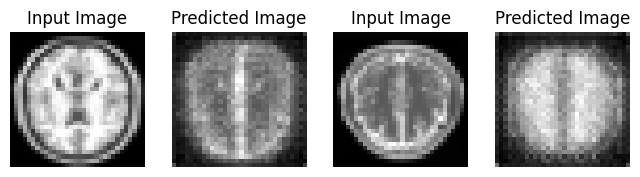

Saving checkpoint for epoch 139 at ./Output/20250501192317/Trained_Model/ckpt-139


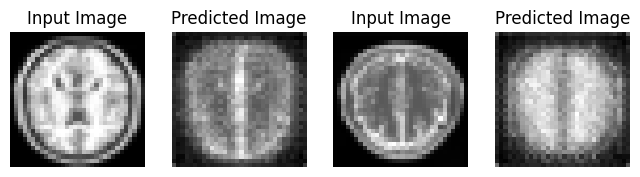

Saving checkpoint for epoch 140 at ./Output/20250501192317/Trained_Model/ckpt-140


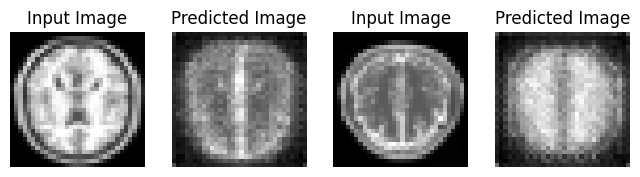

Saving checkpoint for epoch 141 at ./Output/20250501192317/Trained_Model/ckpt-141


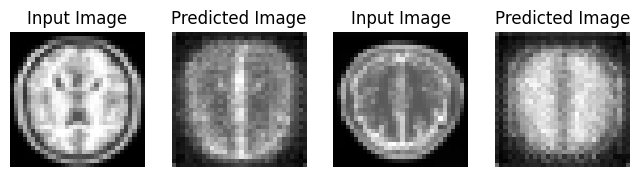

Saving checkpoint for epoch 142 at ./Output/20250501192317/Trained_Model/ckpt-142


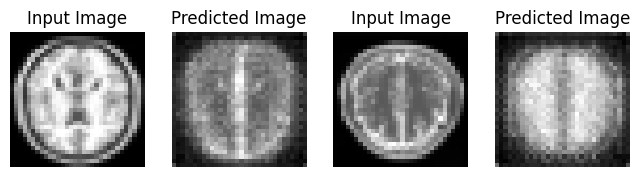

Saving checkpoint for epoch 143 at ./Output/20250501192317/Trained_Model/ckpt-143


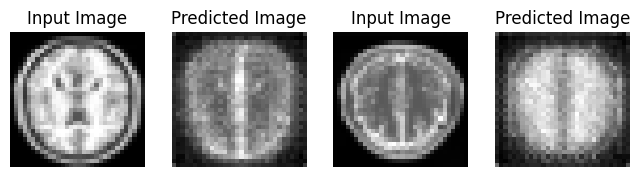

Saving checkpoint for epoch 144 at ./Output/20250501192317/Trained_Model/ckpt-144


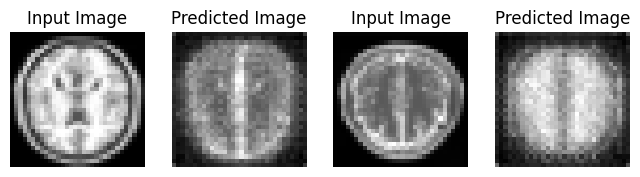

Saving checkpoint for epoch 145 at ./Output/20250501192317/Trained_Model/ckpt-145


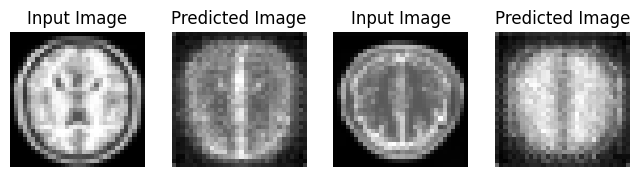

Saving checkpoint for epoch 146 at ./Output/20250501192317/Trained_Model/ckpt-146


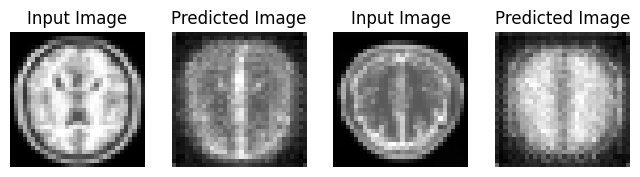

Saving checkpoint for epoch 147 at ./Output/20250501192317/Trained_Model/ckpt-147


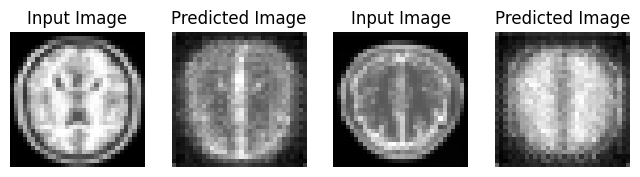

Saving checkpoint for epoch 148 at ./Output/20250501192317/Trained_Model/ckpt-148


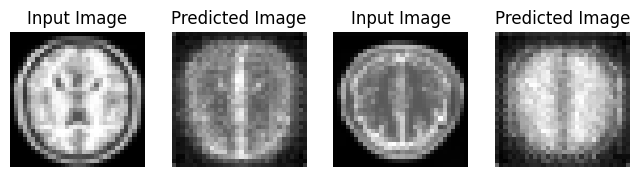

Saving checkpoint for epoch 149 at ./Output/20250501192317/Trained_Model/ckpt-149


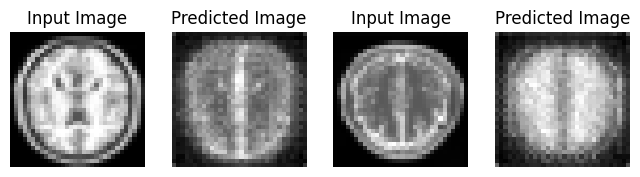

Saving checkpoint for epoch 150 at ./Output/20250501192317/Trained_Model/ckpt-150


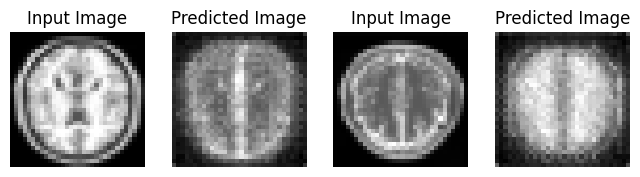

Saving checkpoint for epoch 151 at ./Output/20250501192317/Trained_Model/ckpt-151


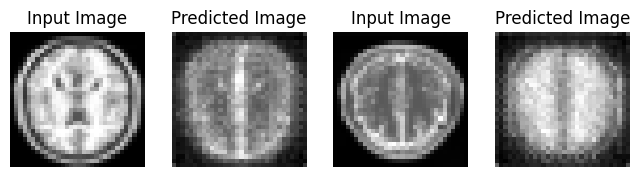

Saving checkpoint for epoch 152 at ./Output/20250501192317/Trained_Model/ckpt-152


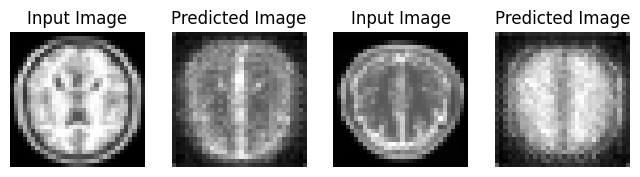

Saving checkpoint for epoch 153 at ./Output/20250501192317/Trained_Model/ckpt-153


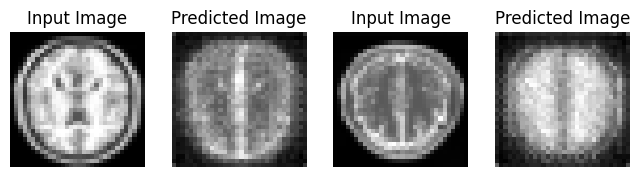

Saving checkpoint for epoch 154 at ./Output/20250501192317/Trained_Model/ckpt-154


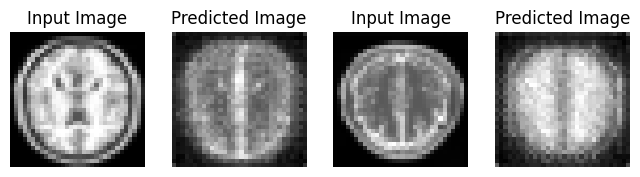

Saving checkpoint for epoch 155 at ./Output/20250501192317/Trained_Model/ckpt-155


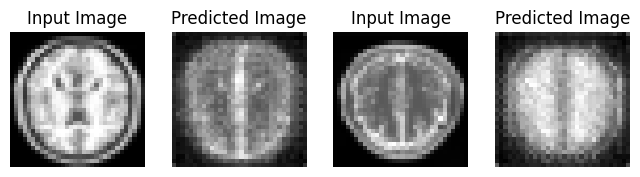

Saving checkpoint for epoch 156 at ./Output/20250501192317/Trained_Model/ckpt-156


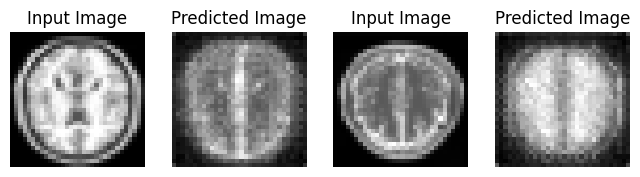

Saving checkpoint for epoch 157 at ./Output/20250501192317/Trained_Model/ckpt-157


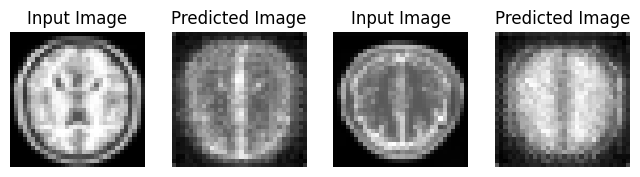

Saving checkpoint for epoch 158 at ./Output/20250501192317/Trained_Model/ckpt-158


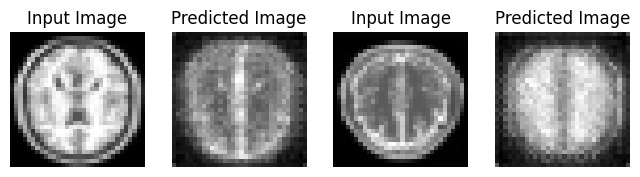

Saving checkpoint for epoch 159 at ./Output/20250501192317/Trained_Model/ckpt-159


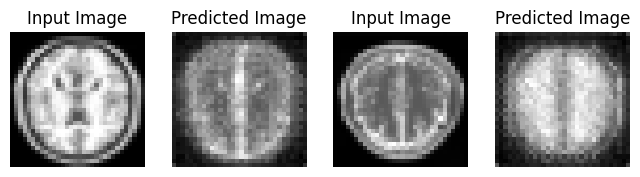

Saving checkpoint for epoch 160 at ./Output/20250501192317/Trained_Model/ckpt-160


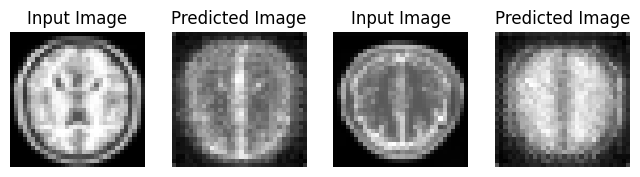

Saving checkpoint for epoch 161 at ./Output/20250501192317/Trained_Model/ckpt-161


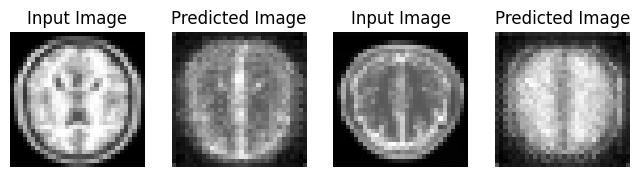

Saving checkpoint for epoch 162 at ./Output/20250501192317/Trained_Model/ckpt-162


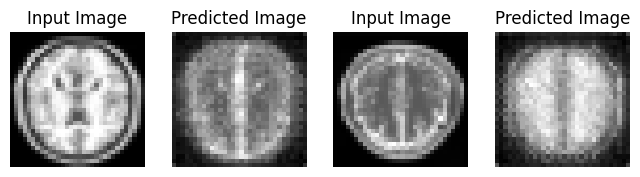

Saving checkpoint for epoch 163 at ./Output/20250501192317/Trained_Model/ckpt-163


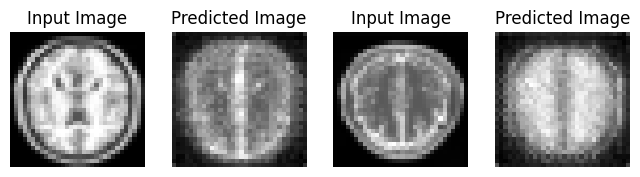

Saving checkpoint for epoch 164 at ./Output/20250501192317/Trained_Model/ckpt-164


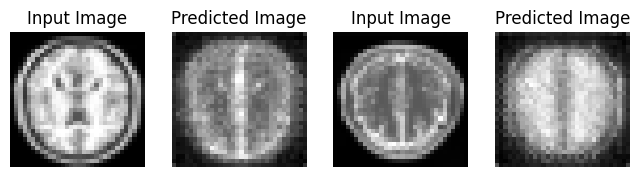

Saving checkpoint for epoch 165 at ./Output/20250501192317/Trained_Model/ckpt-165


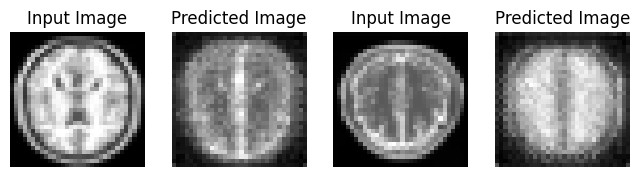

Saving checkpoint for epoch 166 at ./Output/20250501192317/Trained_Model/ckpt-166


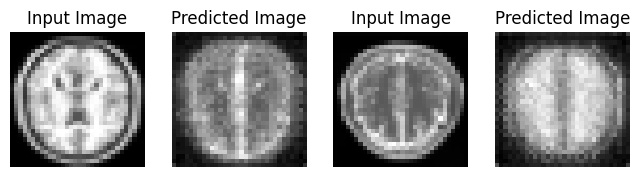

Saving checkpoint for epoch 167 at ./Output/20250501192317/Trained_Model/ckpt-167


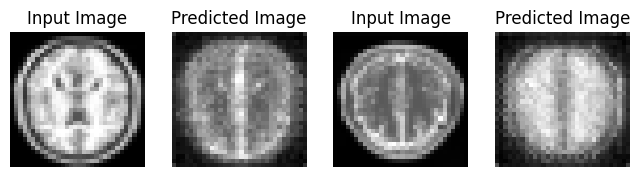

Saving checkpoint for epoch 168 at ./Output/20250501192317/Trained_Model/ckpt-168


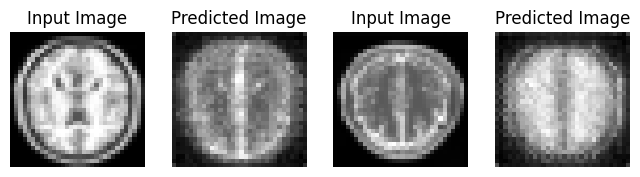

Saving checkpoint for epoch 169 at ./Output/20250501192317/Trained_Model/ckpt-169


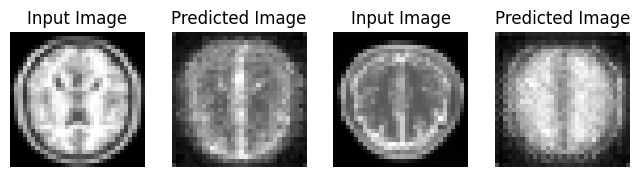

Saving checkpoint for epoch 170 at ./Output/20250501192317/Trained_Model/ckpt-170


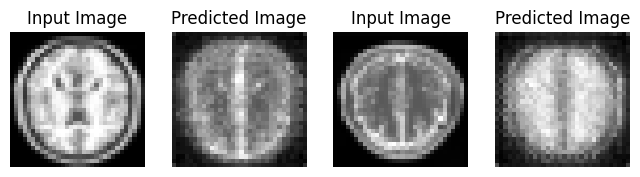

Saving checkpoint for epoch 171 at ./Output/20250501192317/Trained_Model/ckpt-171


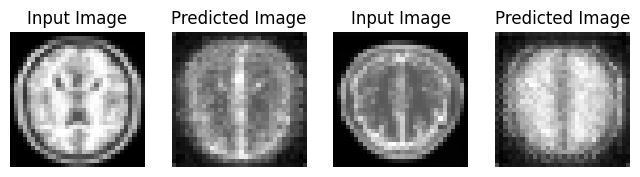

Saving checkpoint for epoch 172 at ./Output/20250501192317/Trained_Model/ckpt-172


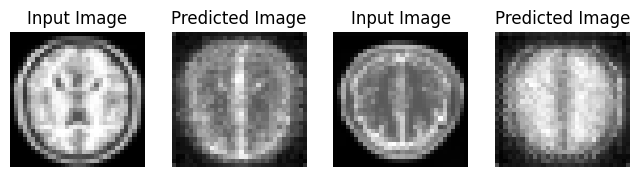

Saving checkpoint for epoch 173 at ./Output/20250501192317/Trained_Model/ckpt-173


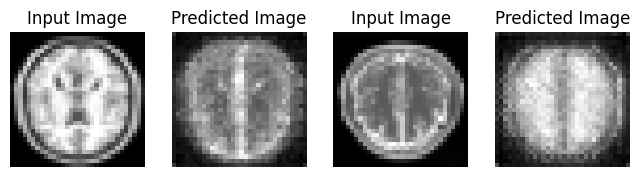

Saving checkpoint for epoch 174 at ./Output/20250501192317/Trained_Model/ckpt-174


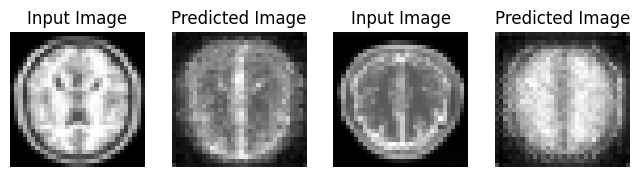

Saving checkpoint for epoch 175 at ./Output/20250501192317/Trained_Model/ckpt-175


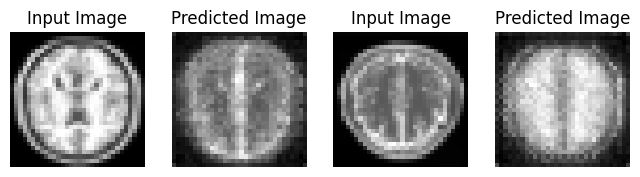

Saving checkpoint for epoch 176 at ./Output/20250501192317/Trained_Model/ckpt-176


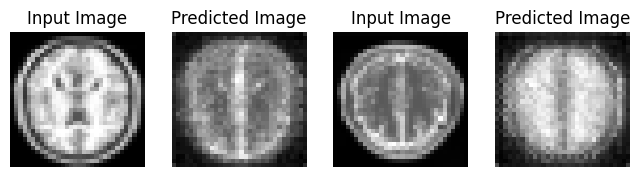

Saving checkpoint for epoch 177 at ./Output/20250501192317/Trained_Model/ckpt-177


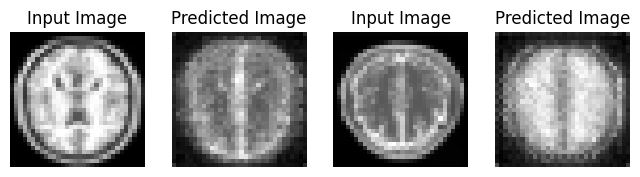

Saving checkpoint for epoch 178 at ./Output/20250501192317/Trained_Model/ckpt-178


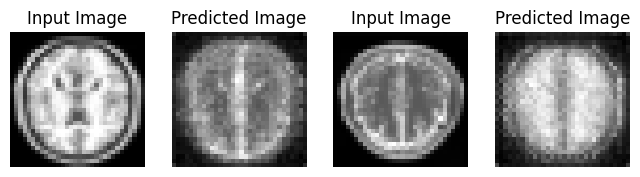

Saving checkpoint for epoch 179 at ./Output/20250501192317/Trained_Model/ckpt-179


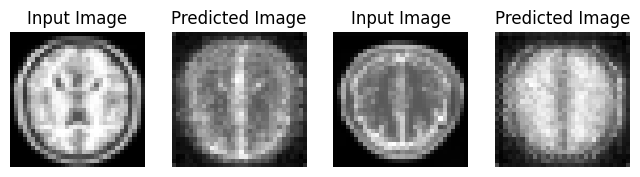

Saving checkpoint for epoch 180 at ./Output/20250501192317/Trained_Model/ckpt-180


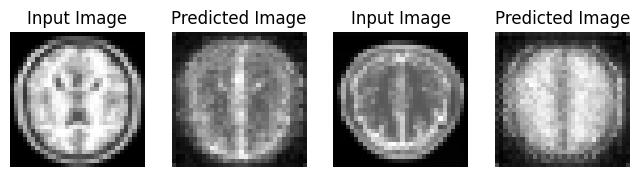

Saving checkpoint for epoch 181 at ./Output/20250501192317/Trained_Model/ckpt-181


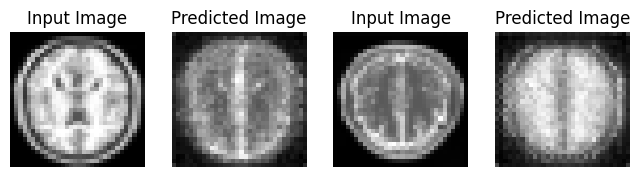

Saving checkpoint for epoch 182 at ./Output/20250501192317/Trained_Model/ckpt-182


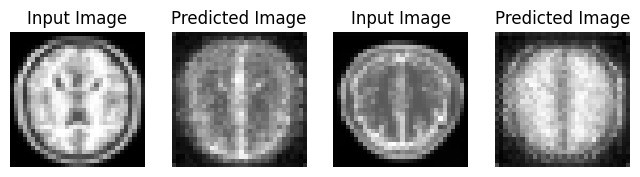

Saving checkpoint for epoch 183 at ./Output/20250501192317/Trained_Model/ckpt-183


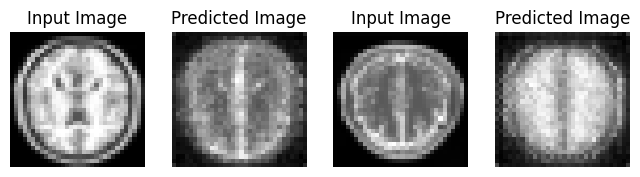

Saving checkpoint for epoch 184 at ./Output/20250501192317/Trained_Model/ckpt-184


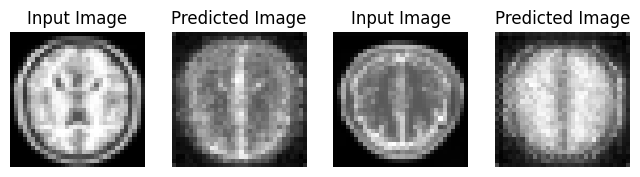

Saving checkpoint for epoch 185 at ./Output/20250501192317/Trained_Model/ckpt-185


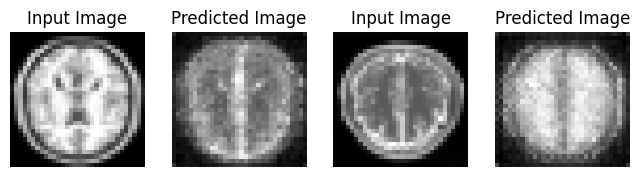

Saving checkpoint for epoch 186 at ./Output/20250501192317/Trained_Model/ckpt-186


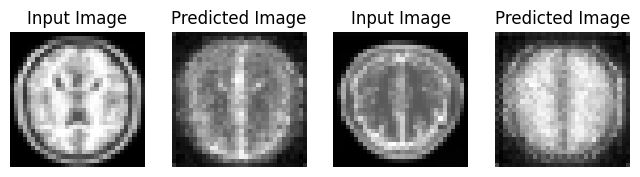

Saving checkpoint for epoch 187 at ./Output/20250501192317/Trained_Model/ckpt-187


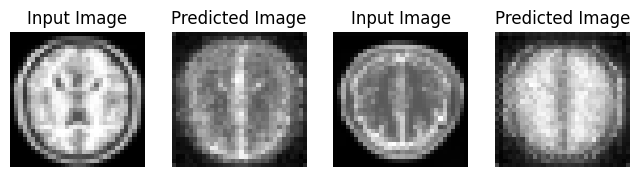

Saving checkpoint for epoch 188 at ./Output/20250501192317/Trained_Model/ckpt-188


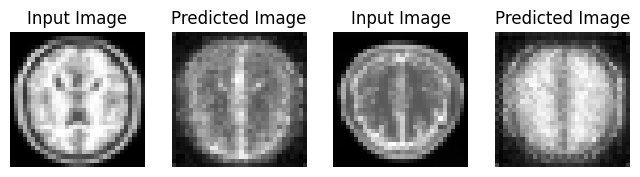

Saving checkpoint for epoch 189 at ./Output/20250501192317/Trained_Model/ckpt-189


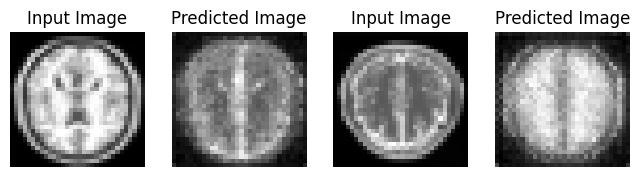

Saving checkpoint for epoch 190 at ./Output/20250501192317/Trained_Model/ckpt-190


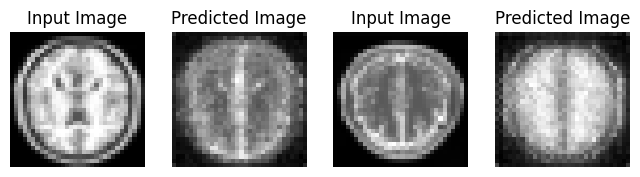

Saving checkpoint for epoch 191 at ./Output/20250501192317/Trained_Model/ckpt-191


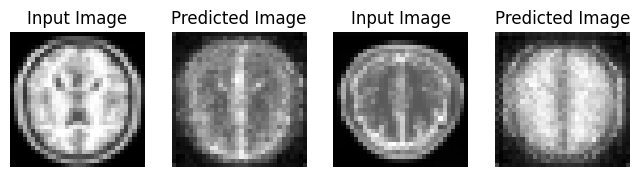

Saving checkpoint for epoch 192 at ./Output/20250501192317/Trained_Model/ckpt-192


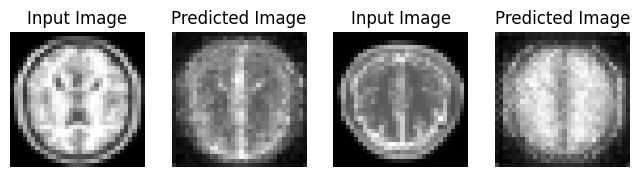

Saving checkpoint for epoch 193 at ./Output/20250501192317/Trained_Model/ckpt-193


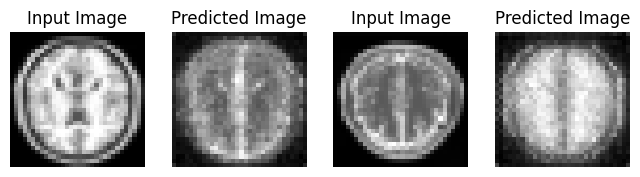

Saving checkpoint for epoch 194 at ./Output/20250501192317/Trained_Model/ckpt-194


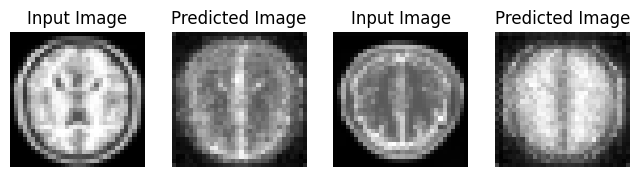

Saving checkpoint for epoch 195 at ./Output/20250501192317/Trained_Model/ckpt-195


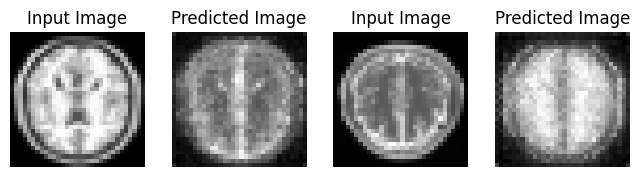

Saving checkpoint for epoch 196 at ./Output/20250501192317/Trained_Model/ckpt-196


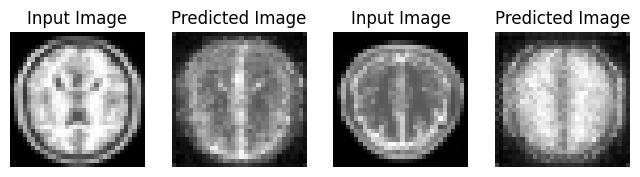

Saving checkpoint for epoch 197 at ./Output/20250501192317/Trained_Model/ckpt-197


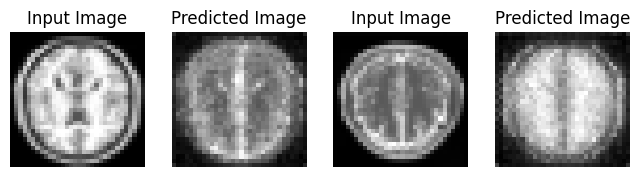

Saving checkpoint for epoch 198 at ./Output/20250501192317/Trained_Model/ckpt-198


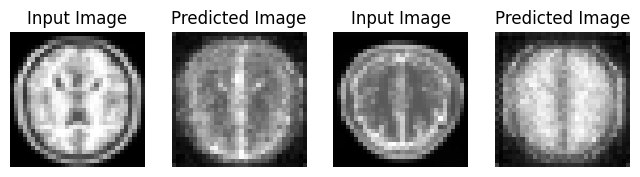

Saving checkpoint for epoch 199 at ./Output/20250501192317/Trained_Model/ckpt-199


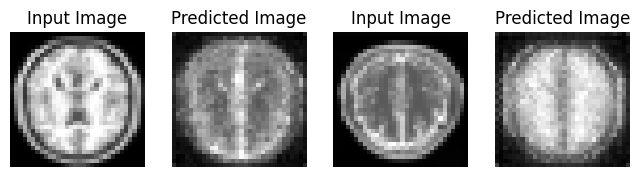

Saving checkpoint for epoch 200 at ./Output/20250501192317/Trained_Model/ckpt-200


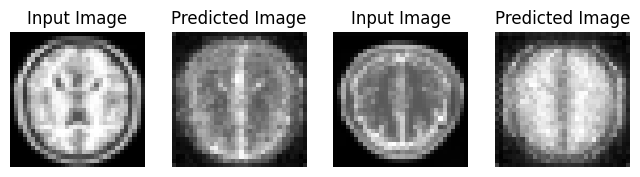

Saving checkpoint for epoch 201 at ./Output/20250501192317/Trained_Model/ckpt-201


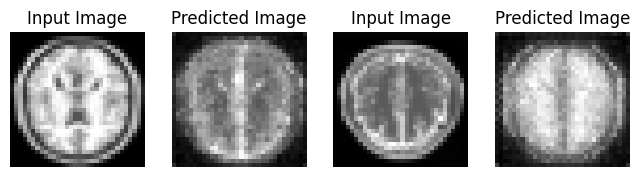

Saving checkpoint for epoch 202 at ./Output/20250501192317/Trained_Model/ckpt-202


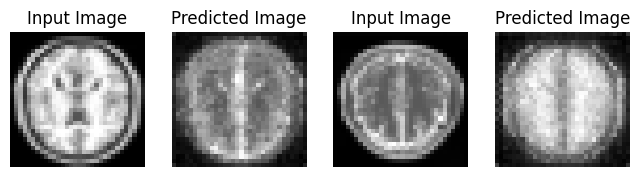

Saving checkpoint for epoch 203 at ./Output/20250501192317/Trained_Model/ckpt-203


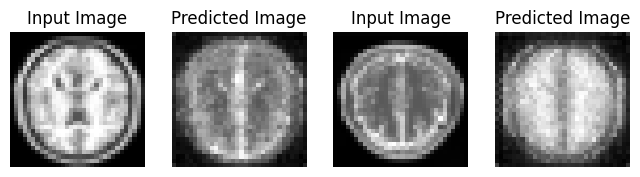

Saving checkpoint for epoch 204 at ./Output/20250501192317/Trained_Model/ckpt-204


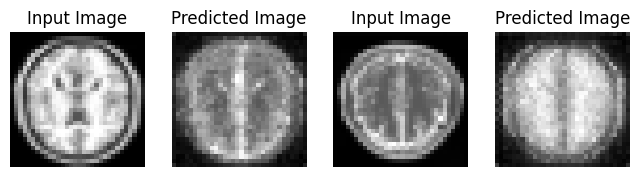

Saving checkpoint for epoch 205 at ./Output/20250501192317/Trained_Model/ckpt-205


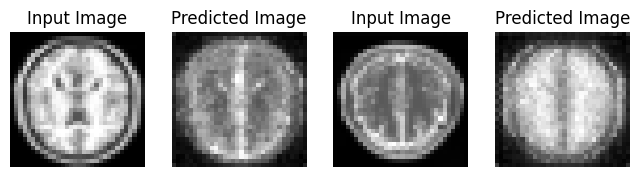

Saving checkpoint for epoch 206 at ./Output/20250501192317/Trained_Model/ckpt-206


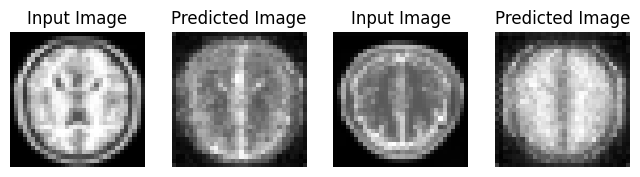

Saving checkpoint for epoch 207 at ./Output/20250501192317/Trained_Model/ckpt-207


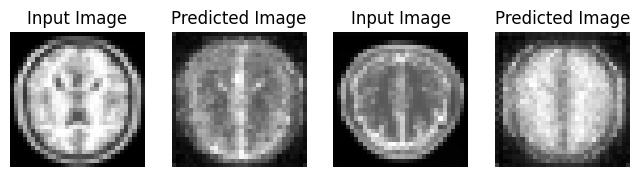

Saving checkpoint for epoch 208 at ./Output/20250501192317/Trained_Model/ckpt-208


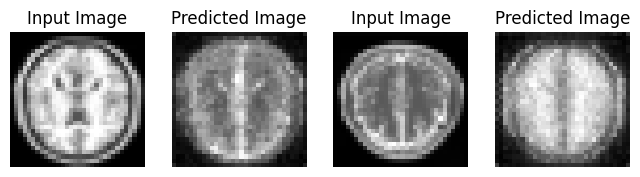

Saving checkpoint for epoch 209 at ./Output/20250501192317/Trained_Model/ckpt-209


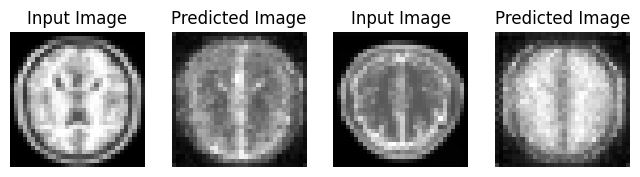

Saving checkpoint for epoch 210 at ./Output/20250501192317/Trained_Model/ckpt-210


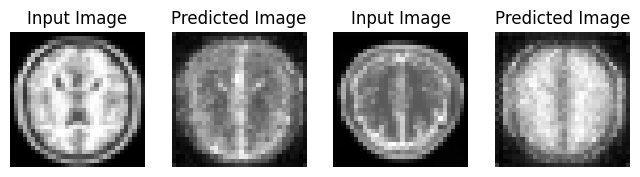

Saving checkpoint for epoch 211 at ./Output/20250501192317/Trained_Model/ckpt-211


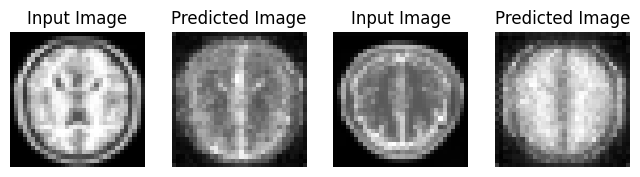

Saving checkpoint for epoch 212 at ./Output/20250501192317/Trained_Model/ckpt-212


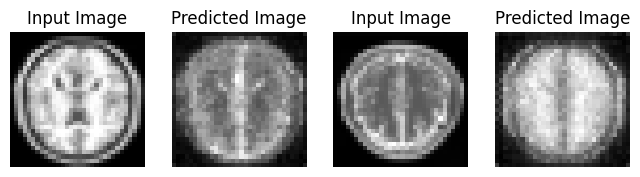

Saving checkpoint for epoch 213 at ./Output/20250501192317/Trained_Model/ckpt-213


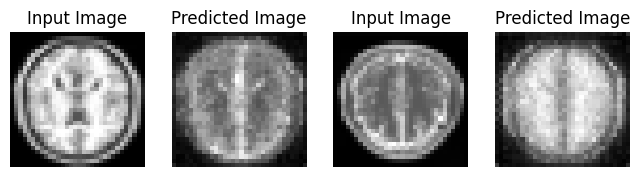

Saving checkpoint for epoch 214 at ./Output/20250501192317/Trained_Model/ckpt-214


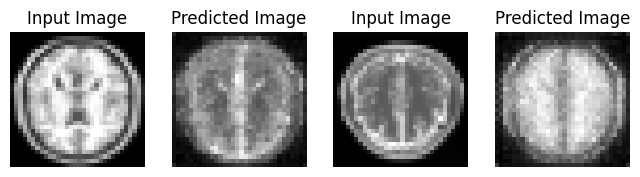

Saving checkpoint for epoch 215 at ./Output/20250501192317/Trained_Model/ckpt-215


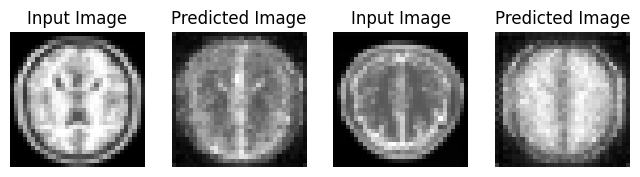

Saving checkpoint for epoch 216 at ./Output/20250501192317/Trained_Model/ckpt-216


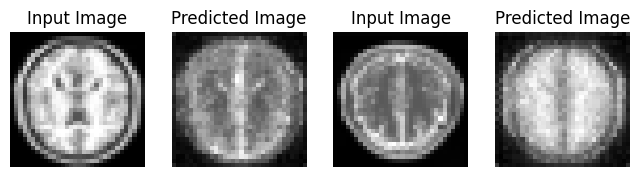

Saving checkpoint for epoch 217 at ./Output/20250501192317/Trained_Model/ckpt-217


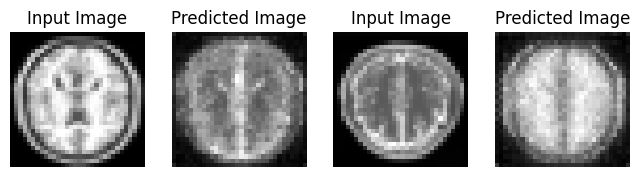

Saving checkpoint for epoch 218 at ./Output/20250501192317/Trained_Model/ckpt-218


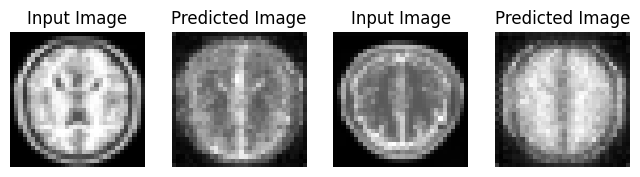

Saving checkpoint for epoch 219 at ./Output/20250501192317/Trained_Model/ckpt-219


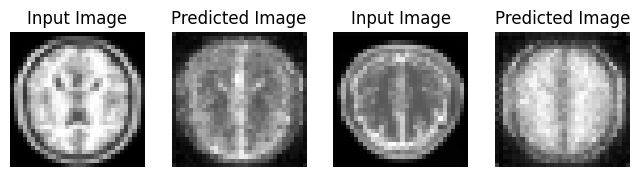

Saving checkpoint for epoch 220 at ./Output/20250501192317/Trained_Model/ckpt-220


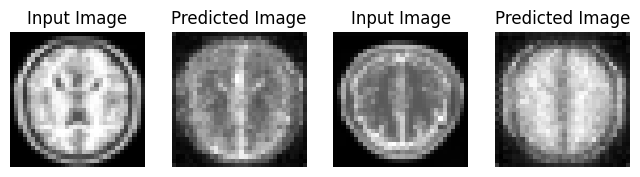

Saving checkpoint for epoch 221 at ./Output/20250501192317/Trained_Model/ckpt-221


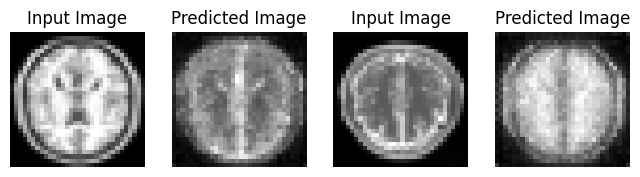

Saving checkpoint for epoch 222 at ./Output/20250501192317/Trained_Model/ckpt-222


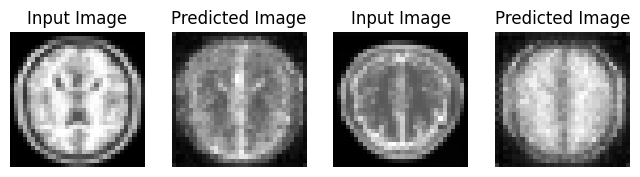

Saving checkpoint for epoch 223 at ./Output/20250501192317/Trained_Model/ckpt-223


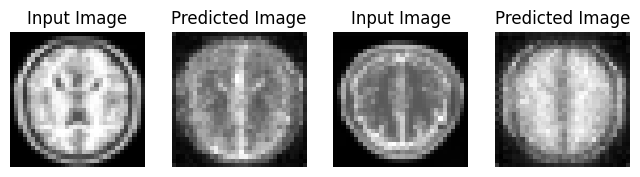

Saving checkpoint for epoch 224 at ./Output/20250501192317/Trained_Model/ckpt-224


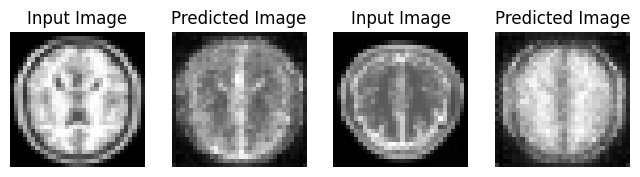

Saving checkpoint for epoch 225 at ./Output/20250501192317/Trained_Model/ckpt-225


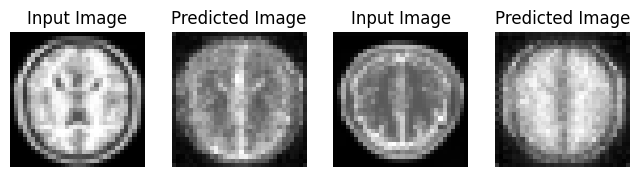

Saving checkpoint for epoch 226 at ./Output/20250501192317/Trained_Model/ckpt-226


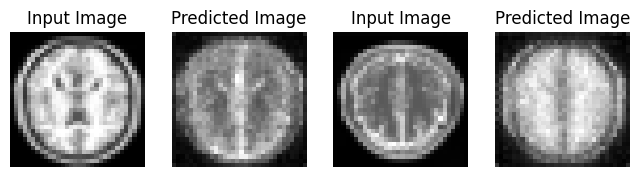

Saving checkpoint for epoch 227 at ./Output/20250501192317/Trained_Model/ckpt-227


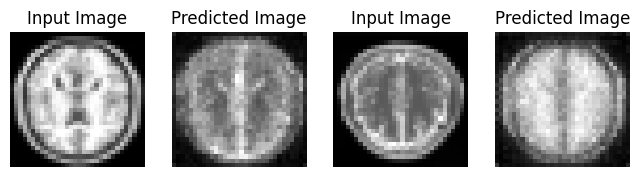

Saving checkpoint for epoch 228 at ./Output/20250501192317/Trained_Model/ckpt-228


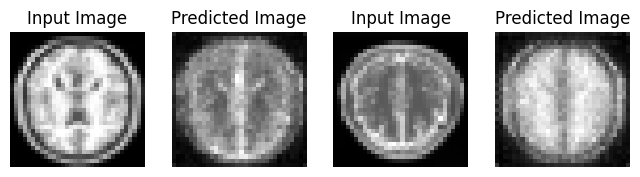

Saving checkpoint for epoch 229 at ./Output/20250501192317/Trained_Model/ckpt-229


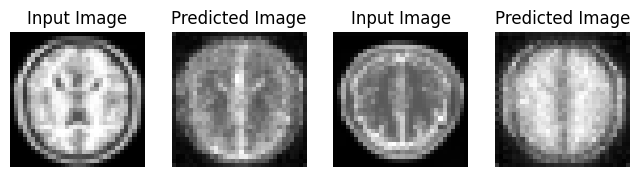

Saving checkpoint for epoch 230 at ./Output/20250501192317/Trained_Model/ckpt-230


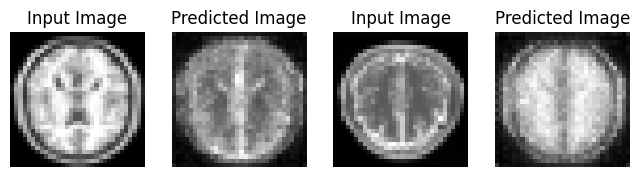

Saving checkpoint for epoch 231 at ./Output/20250501192317/Trained_Model/ckpt-231


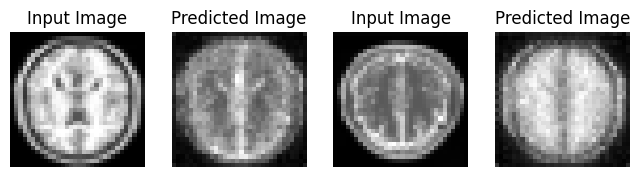

Saving checkpoint for epoch 232 at ./Output/20250501192317/Trained_Model/ckpt-232


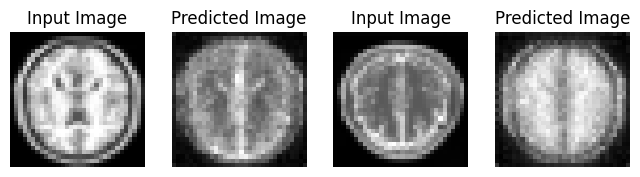

Saving checkpoint for epoch 233 at ./Output/20250501192317/Trained_Model/ckpt-233


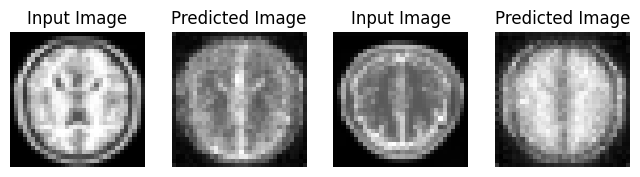

Saving checkpoint for epoch 234 at ./Output/20250501192317/Trained_Model/ckpt-234


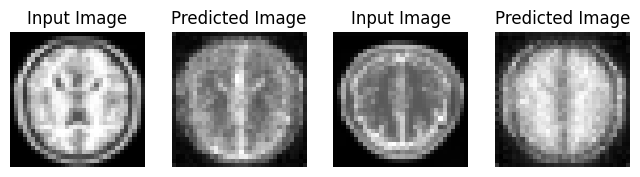

Saving checkpoint for epoch 235 at ./Output/20250501192317/Trained_Model/ckpt-235


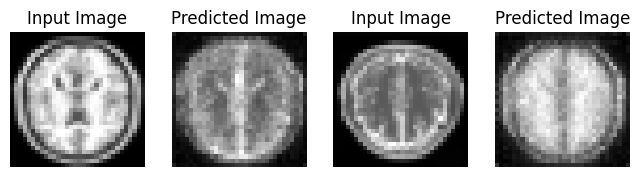

Saving checkpoint for epoch 236 at ./Output/20250501192317/Trained_Model/ckpt-236


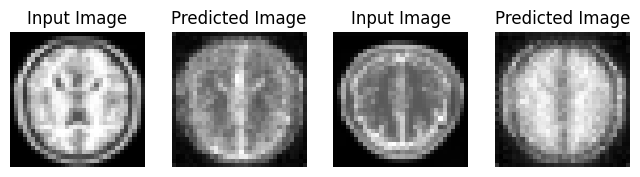

Saving checkpoint for epoch 237 at ./Output/20250501192317/Trained_Model/ckpt-237


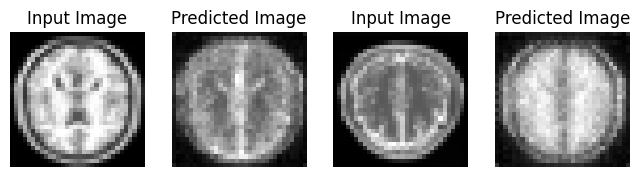

Saving checkpoint for epoch 238 at ./Output/20250501192317/Trained_Model/ckpt-238


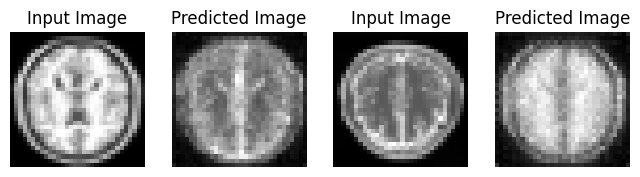

Saving checkpoint for epoch 239 at ./Output/20250501192317/Trained_Model/ckpt-239


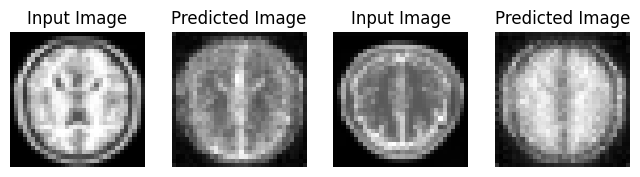

Saving checkpoint for epoch 240 at ./Output/20250501192317/Trained_Model/ckpt-240


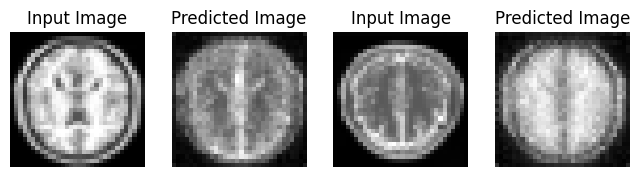

Saving checkpoint for epoch 241 at ./Output/20250501192317/Trained_Model/ckpt-241


2025-05-01 19:26:52.108077: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


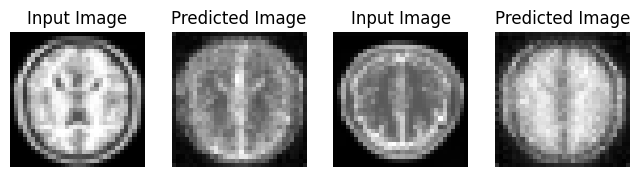

Saving checkpoint for epoch 242 at ./Output/20250501192317/Trained_Model/ckpt-242


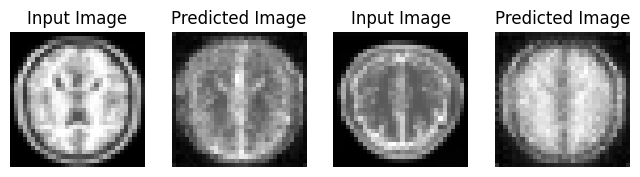

Saving checkpoint for epoch 243 at ./Output/20250501192317/Trained_Model/ckpt-243


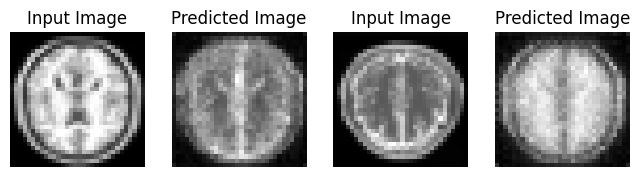

Saving checkpoint for epoch 244 at ./Output/20250501192317/Trained_Model/ckpt-244


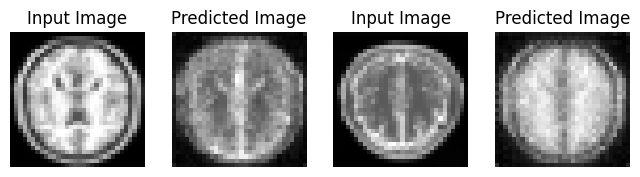

Saving checkpoint for epoch 245 at ./Output/20250501192317/Trained_Model/ckpt-245


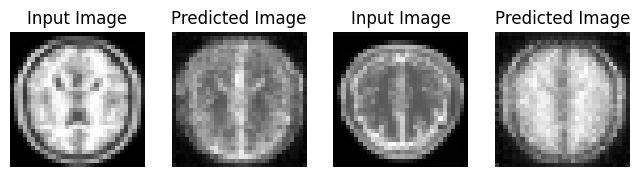

Saving checkpoint for epoch 246 at ./Output/20250501192317/Trained_Model/ckpt-246


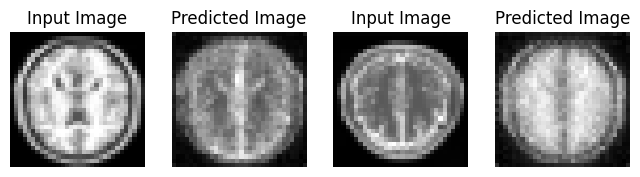

Saving checkpoint for epoch 247 at ./Output/20250501192317/Trained_Model/ckpt-247


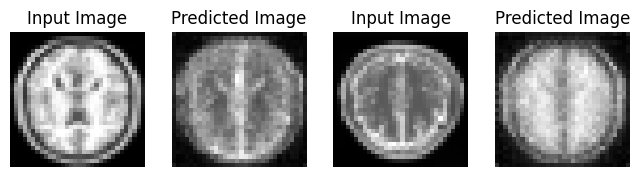

Saving checkpoint for epoch 248 at ./Output/20250501192317/Trained_Model/ckpt-248


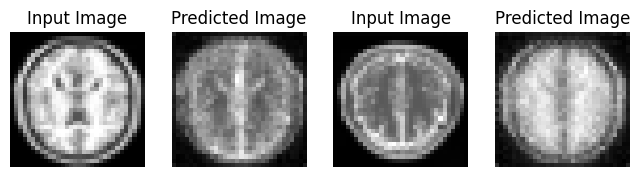

Saving checkpoint for epoch 249 at ./Output/20250501192317/Trained_Model/ckpt-249


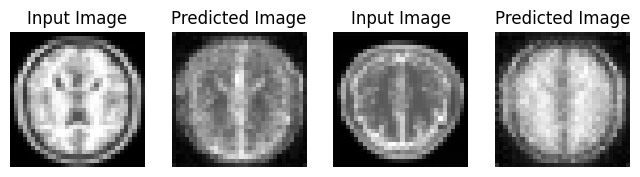

Saving checkpoint for epoch 250 at ./Output/20250501192317/Trained_Model/ckpt-250


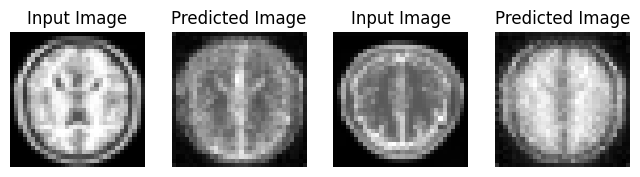

Saving checkpoint for epoch 251 at ./Output/20250501192317/Trained_Model/ckpt-251


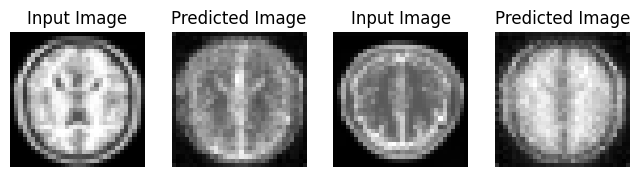

Saving checkpoint for epoch 252 at ./Output/20250501192317/Trained_Model/ckpt-252


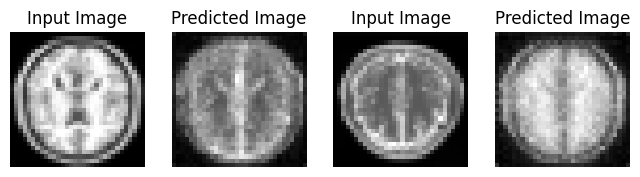

Saving checkpoint for epoch 253 at ./Output/20250501192317/Trained_Model/ckpt-253


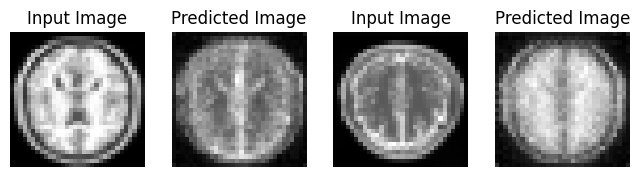

Saving checkpoint for epoch 254 at ./Output/20250501192317/Trained_Model/ckpt-254


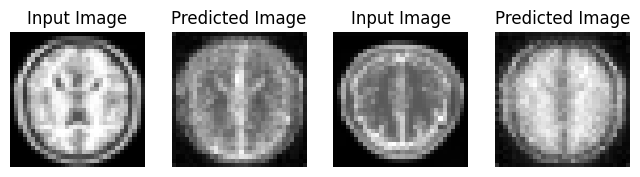

Saving checkpoint for epoch 255 at ./Output/20250501192317/Trained_Model/ckpt-255


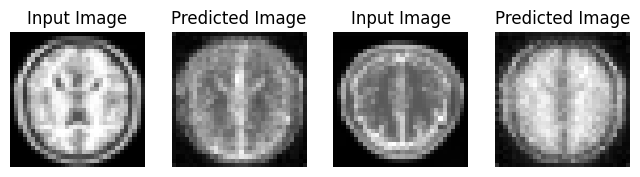

Saving checkpoint for epoch 256 at ./Output/20250501192317/Trained_Model/ckpt-256


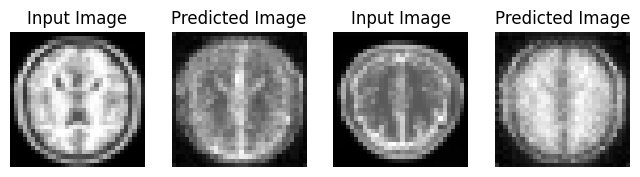

Saving checkpoint for epoch 257 at ./Output/20250501192317/Trained_Model/ckpt-257


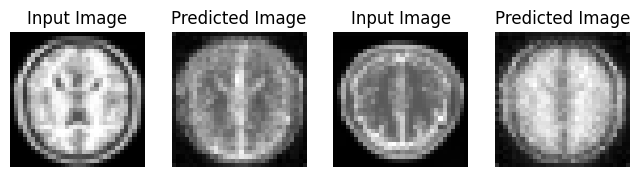

Saving checkpoint for epoch 258 at ./Output/20250501192317/Trained_Model/ckpt-258


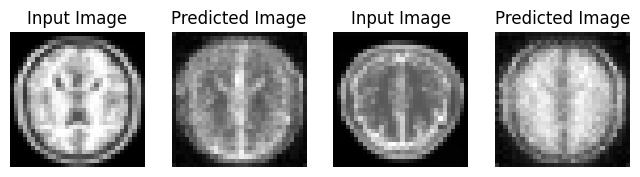

Saving checkpoint for epoch 259 at ./Output/20250501192317/Trained_Model/ckpt-259


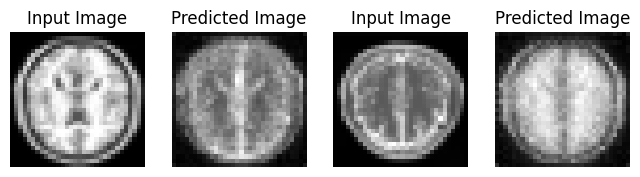

Saving checkpoint for epoch 260 at ./Output/20250501192317/Trained_Model/ckpt-260


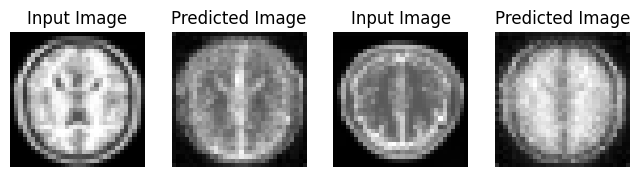

Saving checkpoint for epoch 261 at ./Output/20250501192317/Trained_Model/ckpt-261


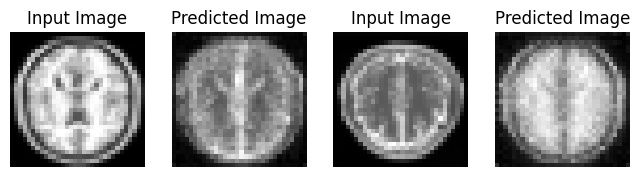

Saving checkpoint for epoch 262 at ./Output/20250501192317/Trained_Model/ckpt-262


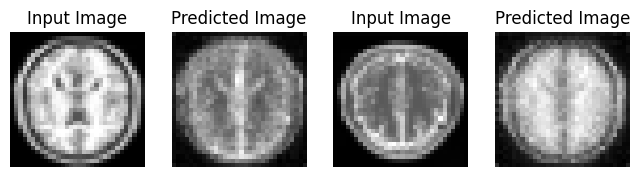

Saving checkpoint for epoch 263 at ./Output/20250501192317/Trained_Model/ckpt-263


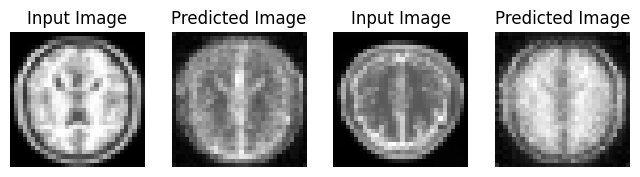

Saving checkpoint for epoch 264 at ./Output/20250501192317/Trained_Model/ckpt-264


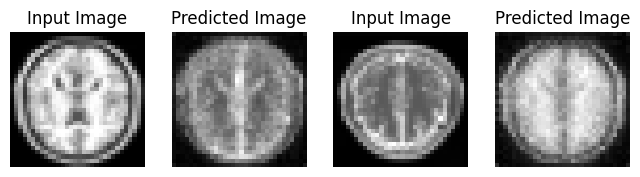

Saving checkpoint for epoch 265 at ./Output/20250501192317/Trained_Model/ckpt-265


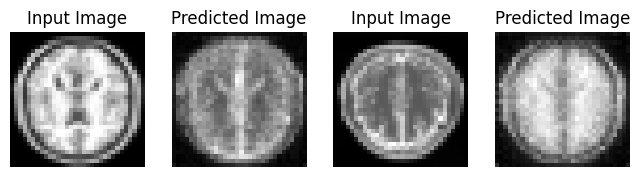

Saving checkpoint for epoch 266 at ./Output/20250501192317/Trained_Model/ckpt-266


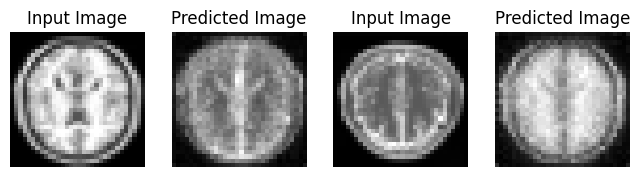

Saving checkpoint for epoch 267 at ./Output/20250501192317/Trained_Model/ckpt-267


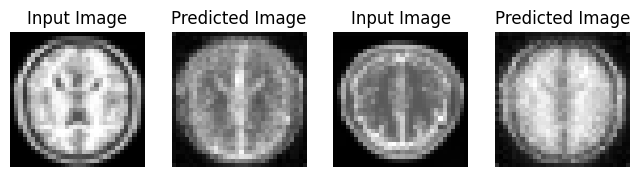

Saving checkpoint for epoch 268 at ./Output/20250501192317/Trained_Model/ckpt-268


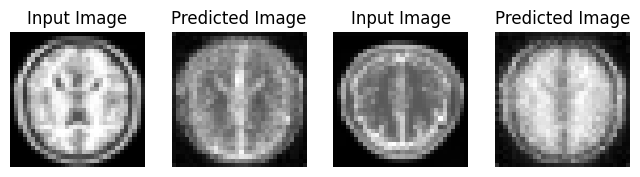

Saving checkpoint for epoch 269 at ./Output/20250501192317/Trained_Model/ckpt-269


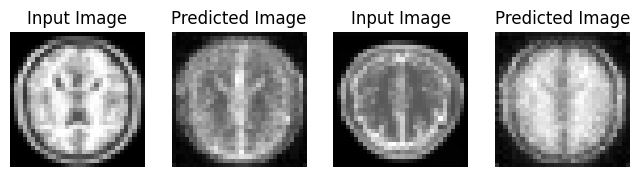

Saving checkpoint for epoch 270 at ./Output/20250501192317/Trained_Model/ckpt-270


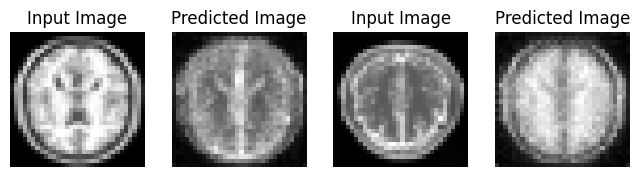

Saving checkpoint for epoch 271 at ./Output/20250501192317/Trained_Model/ckpt-271


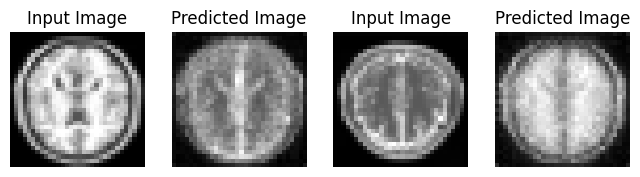

Saving checkpoint for epoch 272 at ./Output/20250501192317/Trained_Model/ckpt-272


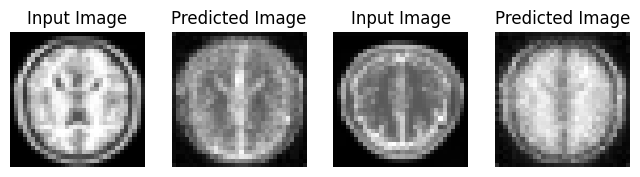

Saving checkpoint for epoch 273 at ./Output/20250501192317/Trained_Model/ckpt-273


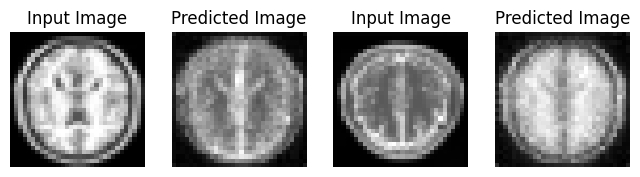

Saving checkpoint for epoch 274 at ./Output/20250501192317/Trained_Model/ckpt-274


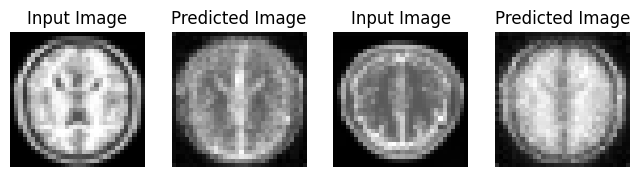

Saving checkpoint for epoch 275 at ./Output/20250501192317/Trained_Model/ckpt-275


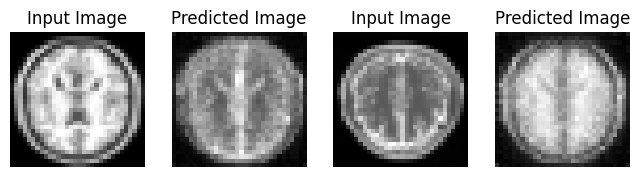

Saving checkpoint for epoch 276 at ./Output/20250501192317/Trained_Model/ckpt-276


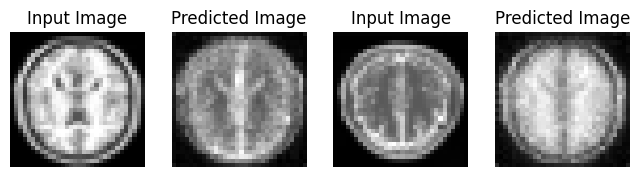

Saving checkpoint for epoch 277 at ./Output/20250501192317/Trained_Model/ckpt-277


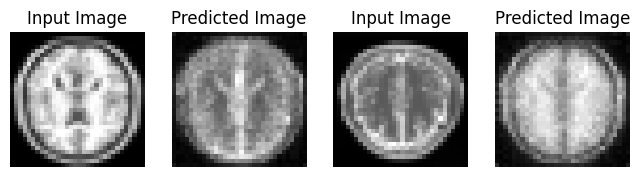

Saving checkpoint for epoch 278 at ./Output/20250501192317/Trained_Model/ckpt-278


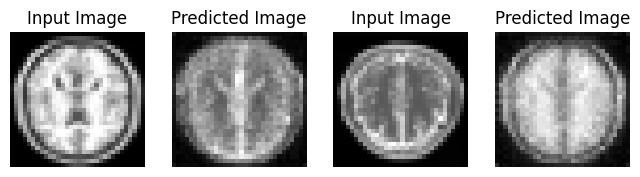

Saving checkpoint for epoch 279 at ./Output/20250501192317/Trained_Model/ckpt-279


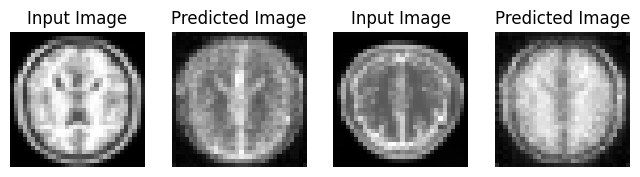

Saving checkpoint for epoch 280 at ./Output/20250501192317/Trained_Model/ckpt-280


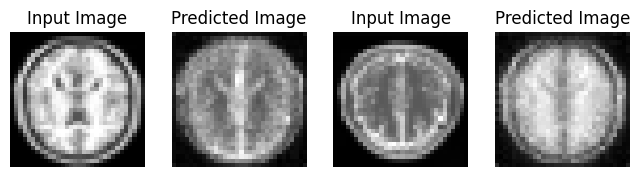

Saving checkpoint for epoch 281 at ./Output/20250501192317/Trained_Model/ckpt-281


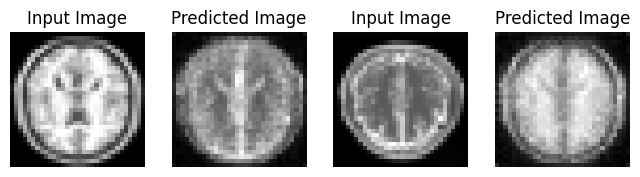

Saving checkpoint for epoch 282 at ./Output/20250501192317/Trained_Model/ckpt-282


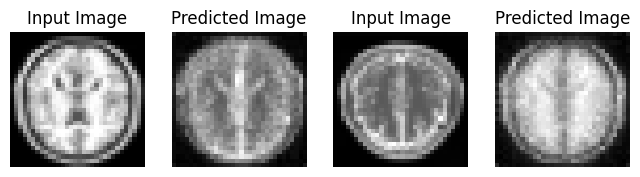

Saving checkpoint for epoch 283 at ./Output/20250501192317/Trained_Model/ckpt-283


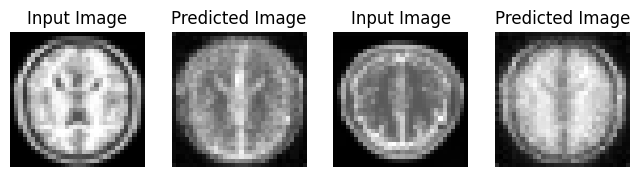

Saving checkpoint for epoch 284 at ./Output/20250501192317/Trained_Model/ckpt-284


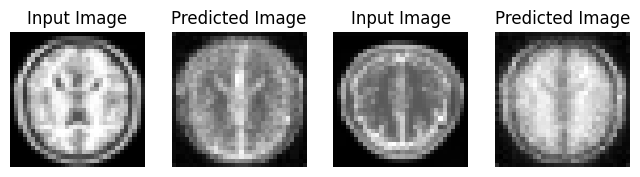

Saving checkpoint for epoch 285 at ./Output/20250501192317/Trained_Model/ckpt-285


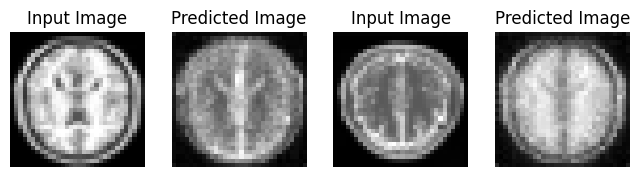

Saving checkpoint for epoch 286 at ./Output/20250501192317/Trained_Model/ckpt-286


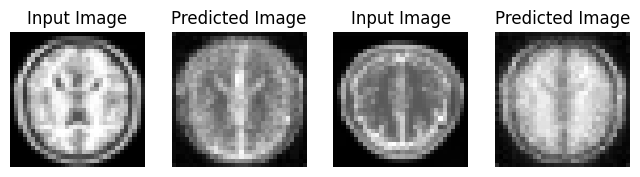

Saving checkpoint for epoch 287 at ./Output/20250501192317/Trained_Model/ckpt-287


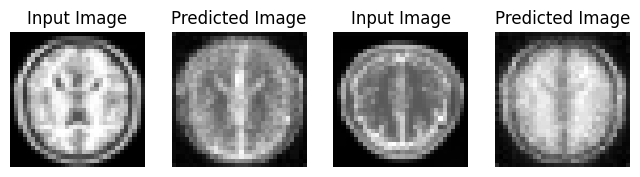

Saving checkpoint for epoch 288 at ./Output/20250501192317/Trained_Model/ckpt-288


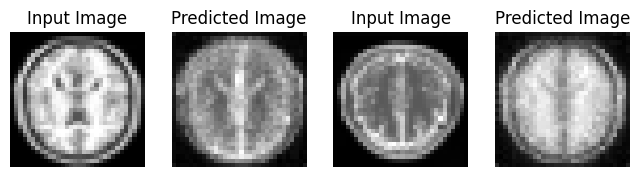

Saving checkpoint for epoch 289 at ./Output/20250501192317/Trained_Model/ckpt-289


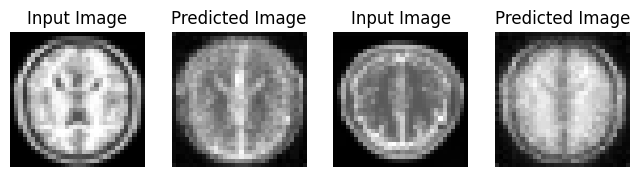

Saving checkpoint for epoch 290 at ./Output/20250501192317/Trained_Model/ckpt-290


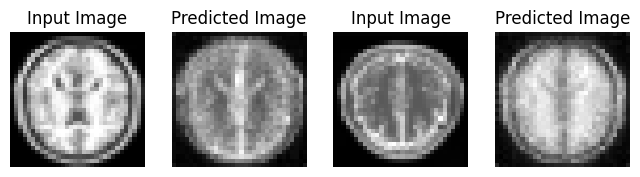

Saving checkpoint for epoch 291 at ./Output/20250501192317/Trained_Model/ckpt-291


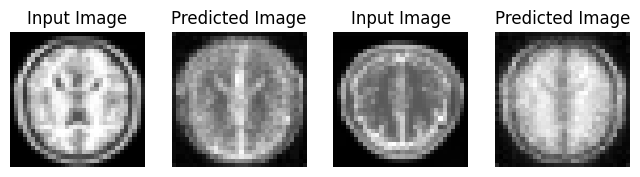

Saving checkpoint for epoch 292 at ./Output/20250501192317/Trained_Model/ckpt-292


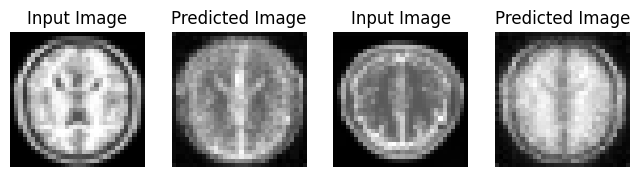

Saving checkpoint for epoch 293 at ./Output/20250501192317/Trained_Model/ckpt-293


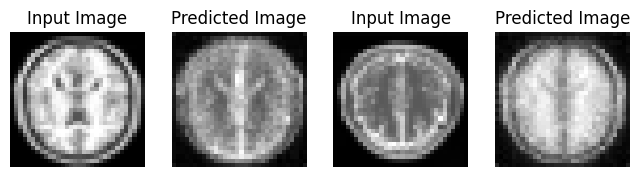

Saving checkpoint for epoch 294 at ./Output/20250501192317/Trained_Model/ckpt-294


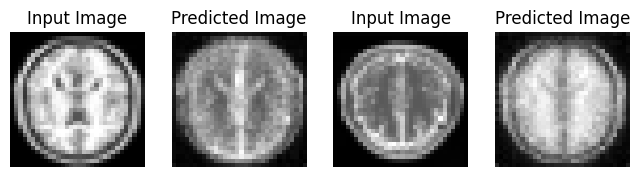

Saving checkpoint for epoch 295 at ./Output/20250501192317/Trained_Model/ckpt-295


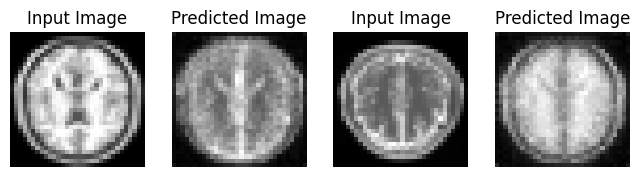

Saving checkpoint for epoch 296 at ./Output/20250501192317/Trained_Model/ckpt-296


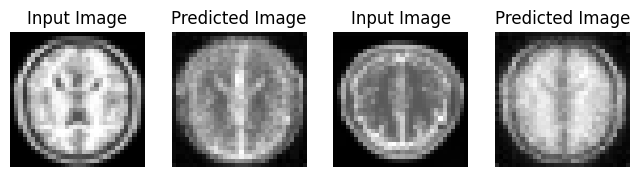

Saving checkpoint for epoch 297 at ./Output/20250501192317/Trained_Model/ckpt-297


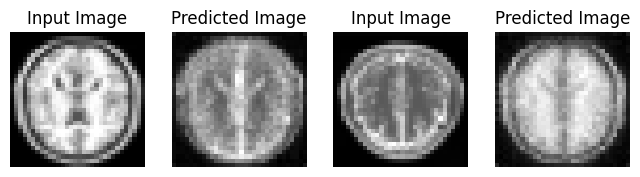

Saving checkpoint for epoch 298 at ./Output/20250501192317/Trained_Model/ckpt-298


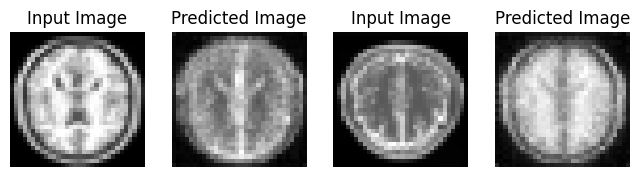

Saving checkpoint for epoch 299 at ./Output/20250501192317/Trained_Model/ckpt-299


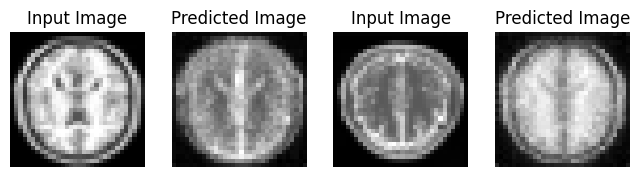

Saving checkpoint for epoch 300 at ./Output/20250501192317/Trained_Model/ckpt-300


In [227]:
for epoch in range(1, EPOCHS+1):
    for image_x, image_y in tf.data.Dataset.zip((t1_img_data, t2_img_data)):
        train_step(image_x, image_y)
    generate_images(generator_g, sample_t1_data, generator_f, sample_t2_data, epoch)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

In [229]:
anim_file = TEMP_FOLDER + 'cyclegan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob( TEMP_FOLDER +'image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

/tmp/ipykernel_288730/1302020759.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipykernel_288730/1302020759.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



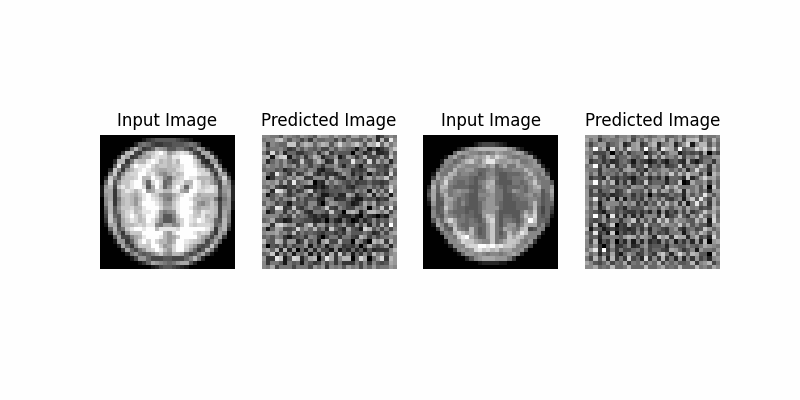

In [230]:
embed.embed_file(anim_file)